# 0.0. Imports 


In [1]:
import sys
print(sys.executable)

/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/bin/python


In [27]:
import pandas            as pd 
import numpy             as np 
import seaborn           as sns
import matplotlib.pyplot as plt
import datetime          as dt
import xgboost           as xgb
import inflection  
import math


from scipy                 import stats   as ss
from sklearn               import metrics as mt


from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1. Helper Functions

In [3]:
# Função da correlação
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm ) [0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ) )

# Função para Descobrir o MAPE
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) ) 

# Função para descobrir as metricas 
def ml_error( model_name, y, yhat ):
    mae = mt.mean_absolute_error( y, yhat ) 
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mt.mean_squared_error( y, yhat) )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE':  mae,
                          'MAPE': mape,
                          'RMSE': rmse
                         }, index=[0] )

# Função para execução do Cross Validation dos modelos
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\n KFold Number: {}'.format( k ) )
        # Start and End Date for Validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # Filtering DataSet
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date ) ]

        # Training and Validation DataSet

        # Training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # Validation 
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # Model
        m = model.fit( xtraining, ytraining )

        # Prediction
        yhat = m.predict( xvalidation )

        # Performance 
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # Store Performance Of Each Fold Iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )


    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),  
                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),  
                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )




## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns 

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Rename Columns 
df1.columns = cols_new 


In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension 

In [9]:
df1.shape

(1017209, 18)

## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
753137,183,7,2013-08-25,0,0,0,0,0,0,a,a,9670.0,NaN,NaN,0,NaN,NaN,NaN


In [14]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
     
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 
df1['promo_interval'].fillna( 0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 



In [15]:
df1.isna().sum()



store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Dtypes

In [16]:
df1['competition_open_since_month'] =  df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] =  df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] =  df1['promo2_since_year'].astype( int )



## 1.7. Descriptive Statistical 

In [17]:
num_attributes =  df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes =  df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

m.columns = [ 'attributes', 'min', 'max','range','mean', 'median', 'std', 'skew', 'kurtosis']





In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

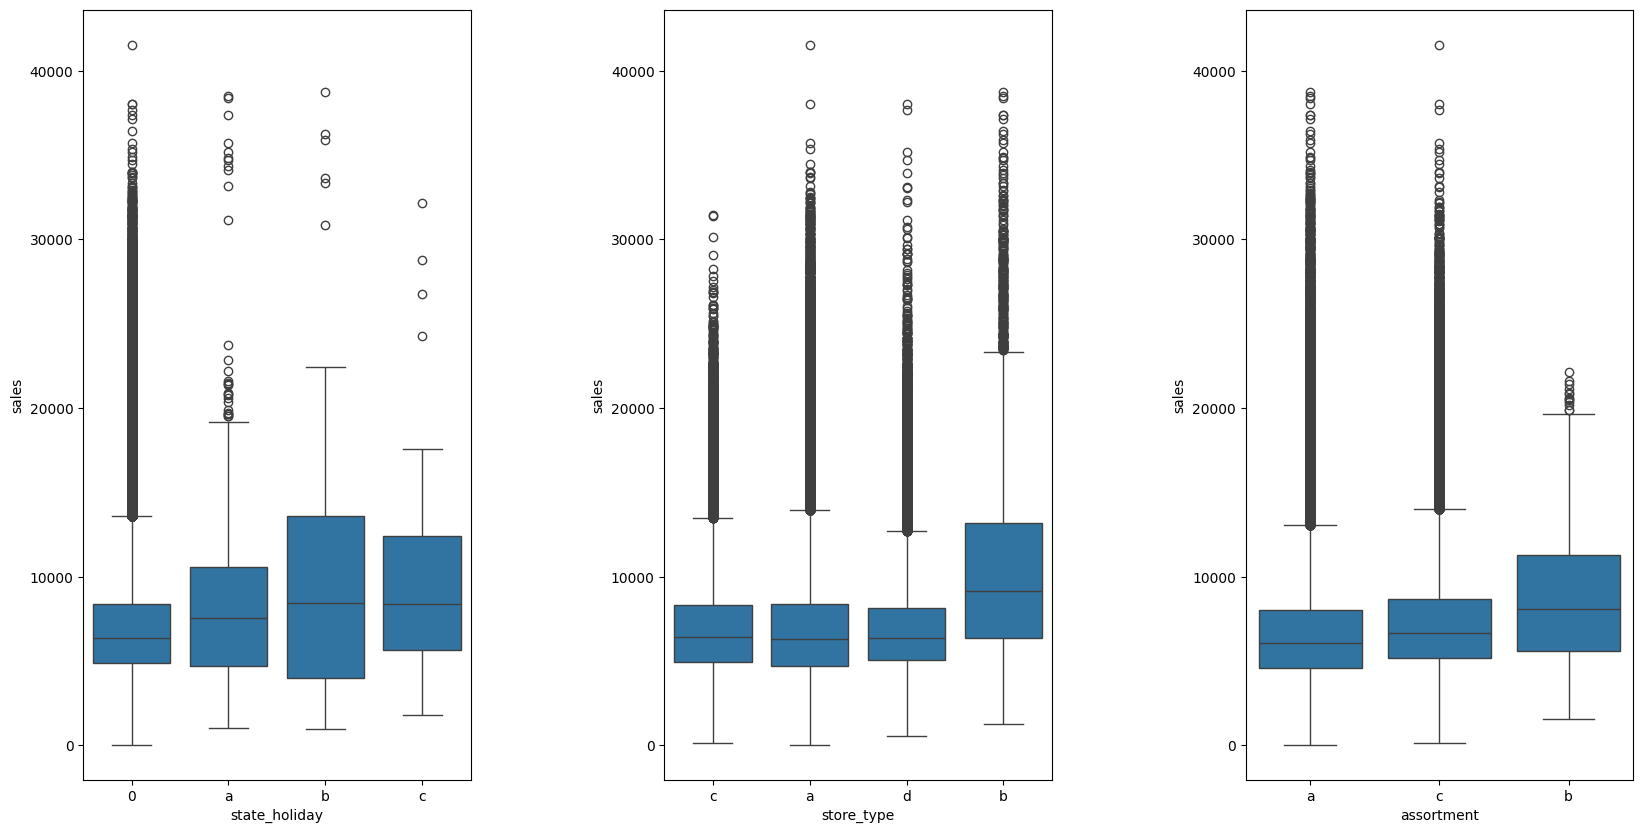

In [21]:
aux1 = df1[( df1['state_holiday'] != 0 ) & ( df1['sales'] > 0 ) ]

plt.figure(figsize=(20, 10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# Ajustando o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.5)

plt.show()



# 2.0. Feature Engineering 

In [22]:
df2 = df1.copy()

## 2.1. Mental Map Hypothesis 

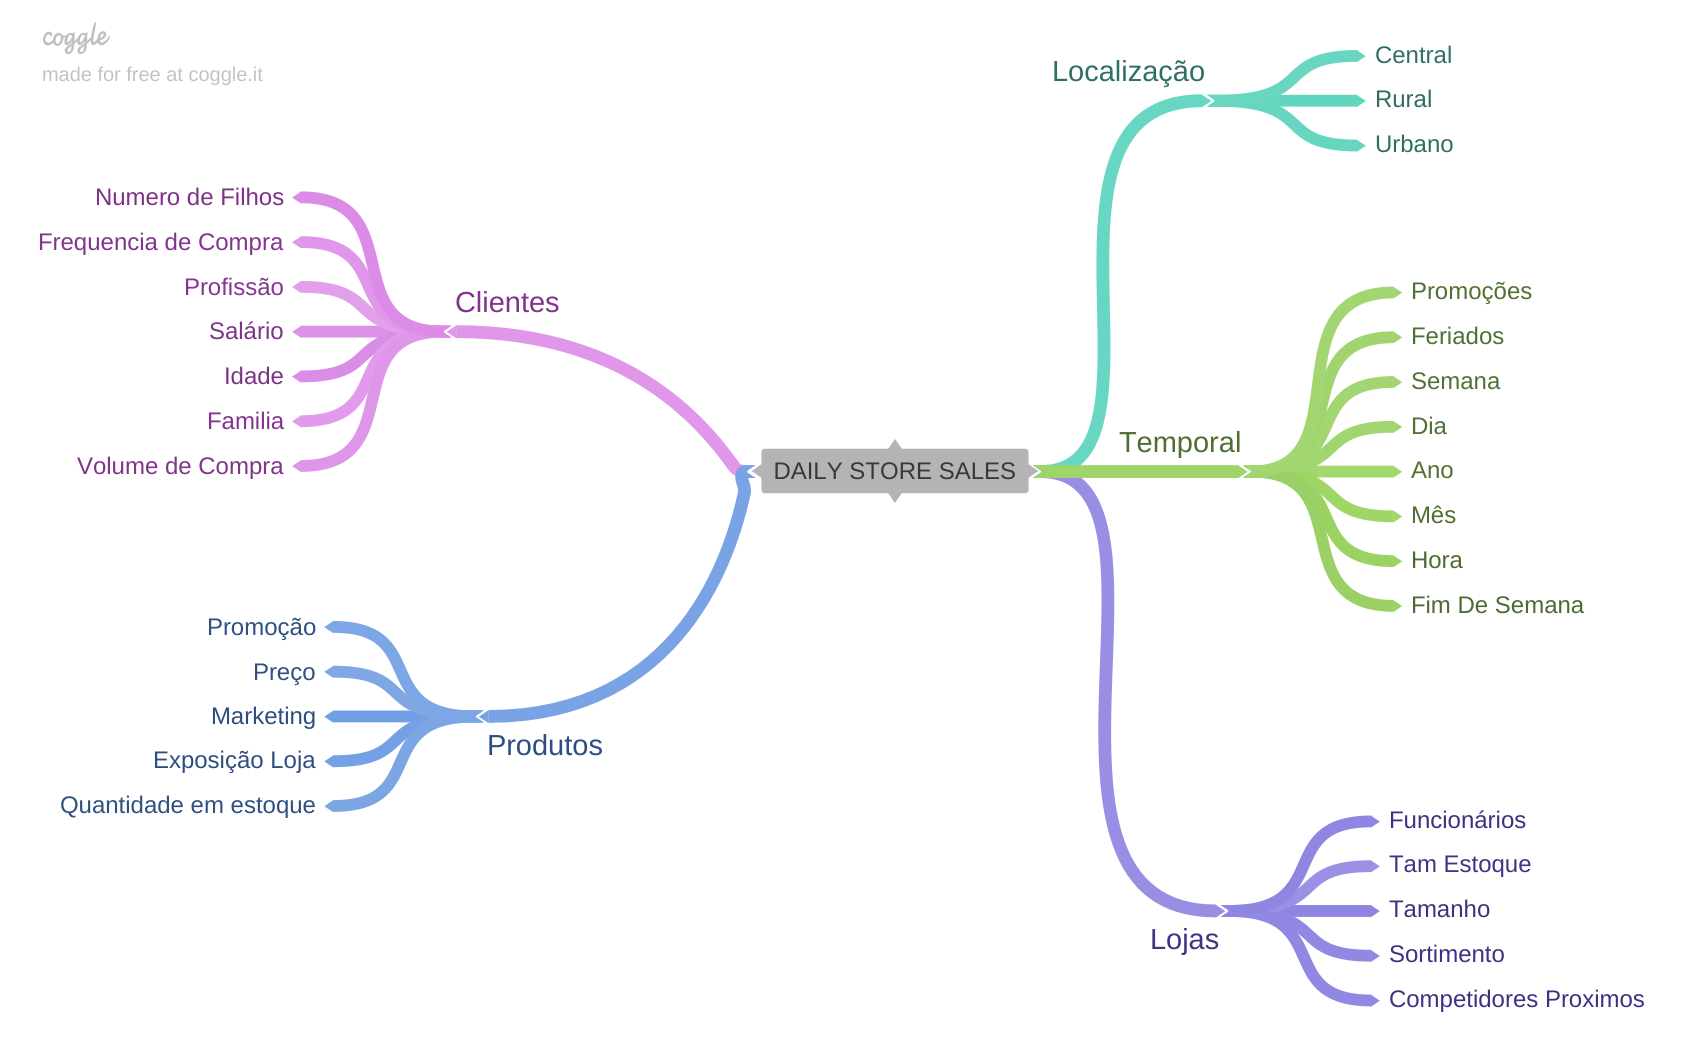

In [23]:
Image( 'img/MindMapHip.png' )

## 2.1. Hypothesis Creation 

### 2.1.1. Store Hypothesis 

**1.** Lojas com maior quadro de funcionários, deveriam vender mais. 

**2.** Lojas com estoque maior, deveriam vender mais. 

**3.** Lojas com porte maior, deveriam vender mais. 

**4.** Lojas com maior sortimento de produtos, deveriam vender mais.

**5.** Lojas com concorrentes mais proximos deveriam vender menos

**6.** Lojas com concorrentes a mais tempo deveriam vender mais.

### 2.1.2. Product Hypothesis 

**1.** Lojas que tem mais investimento em Marketing, deveriam vender mais. 

**2.** Lojas que expoem mais produtos nas vitrines, deveriam vender mais. 

**3.** Lojas que possuem o melhor preço, deveriam vender mais. 

**4.** Lojas que possuem o preço baixo por mais tempo, deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.




### 2.1.3. Time Hypothesis 

**1.** lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos. 

**3.** Lojas deveriam vender mais no segundo semestre do ano. 

**4.** Lojas Deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas Deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escoalres.

## 2.2. Final Hipóthesis List

**1.** Lojas com maior sortimento de produtos, deveriam vender mais.

**2.** Lojas com concorrentes mais proximos deveriam vender menos

**3.** Lojas com concorrentes a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos. 

**9.** Lojas deveriam vender mais no segundo semestre do ano. 

**10.** Lojas Deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas Deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escoalres.

## 2.3. Feature Engineering 

In [28]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week Of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# Competition Since
df2['competition_since'] = df2.apply( lambda x: dt.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days ).astype( int )

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day' ) 




In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Variable Filtering 

In [30]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Line Filtering 

In [31]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ] 

## 3.2. Columns Filtering 

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.columns 

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis 

In [34]:
df4 = df3.copy()

## 4.1. Univariate Analysis 

### 4.1.1. Response Variable

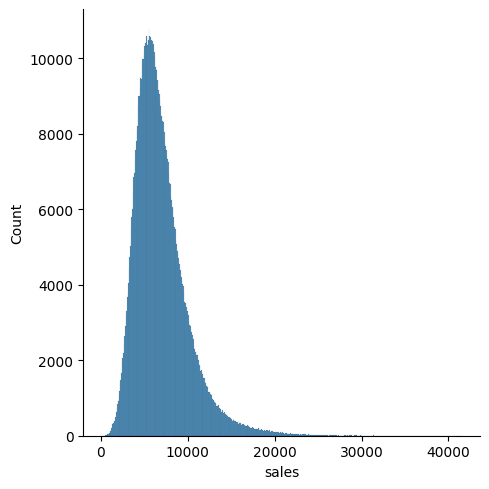

In [35]:
sns.displot( df4['sales'] )

### 4.1.2. Numerical Variables

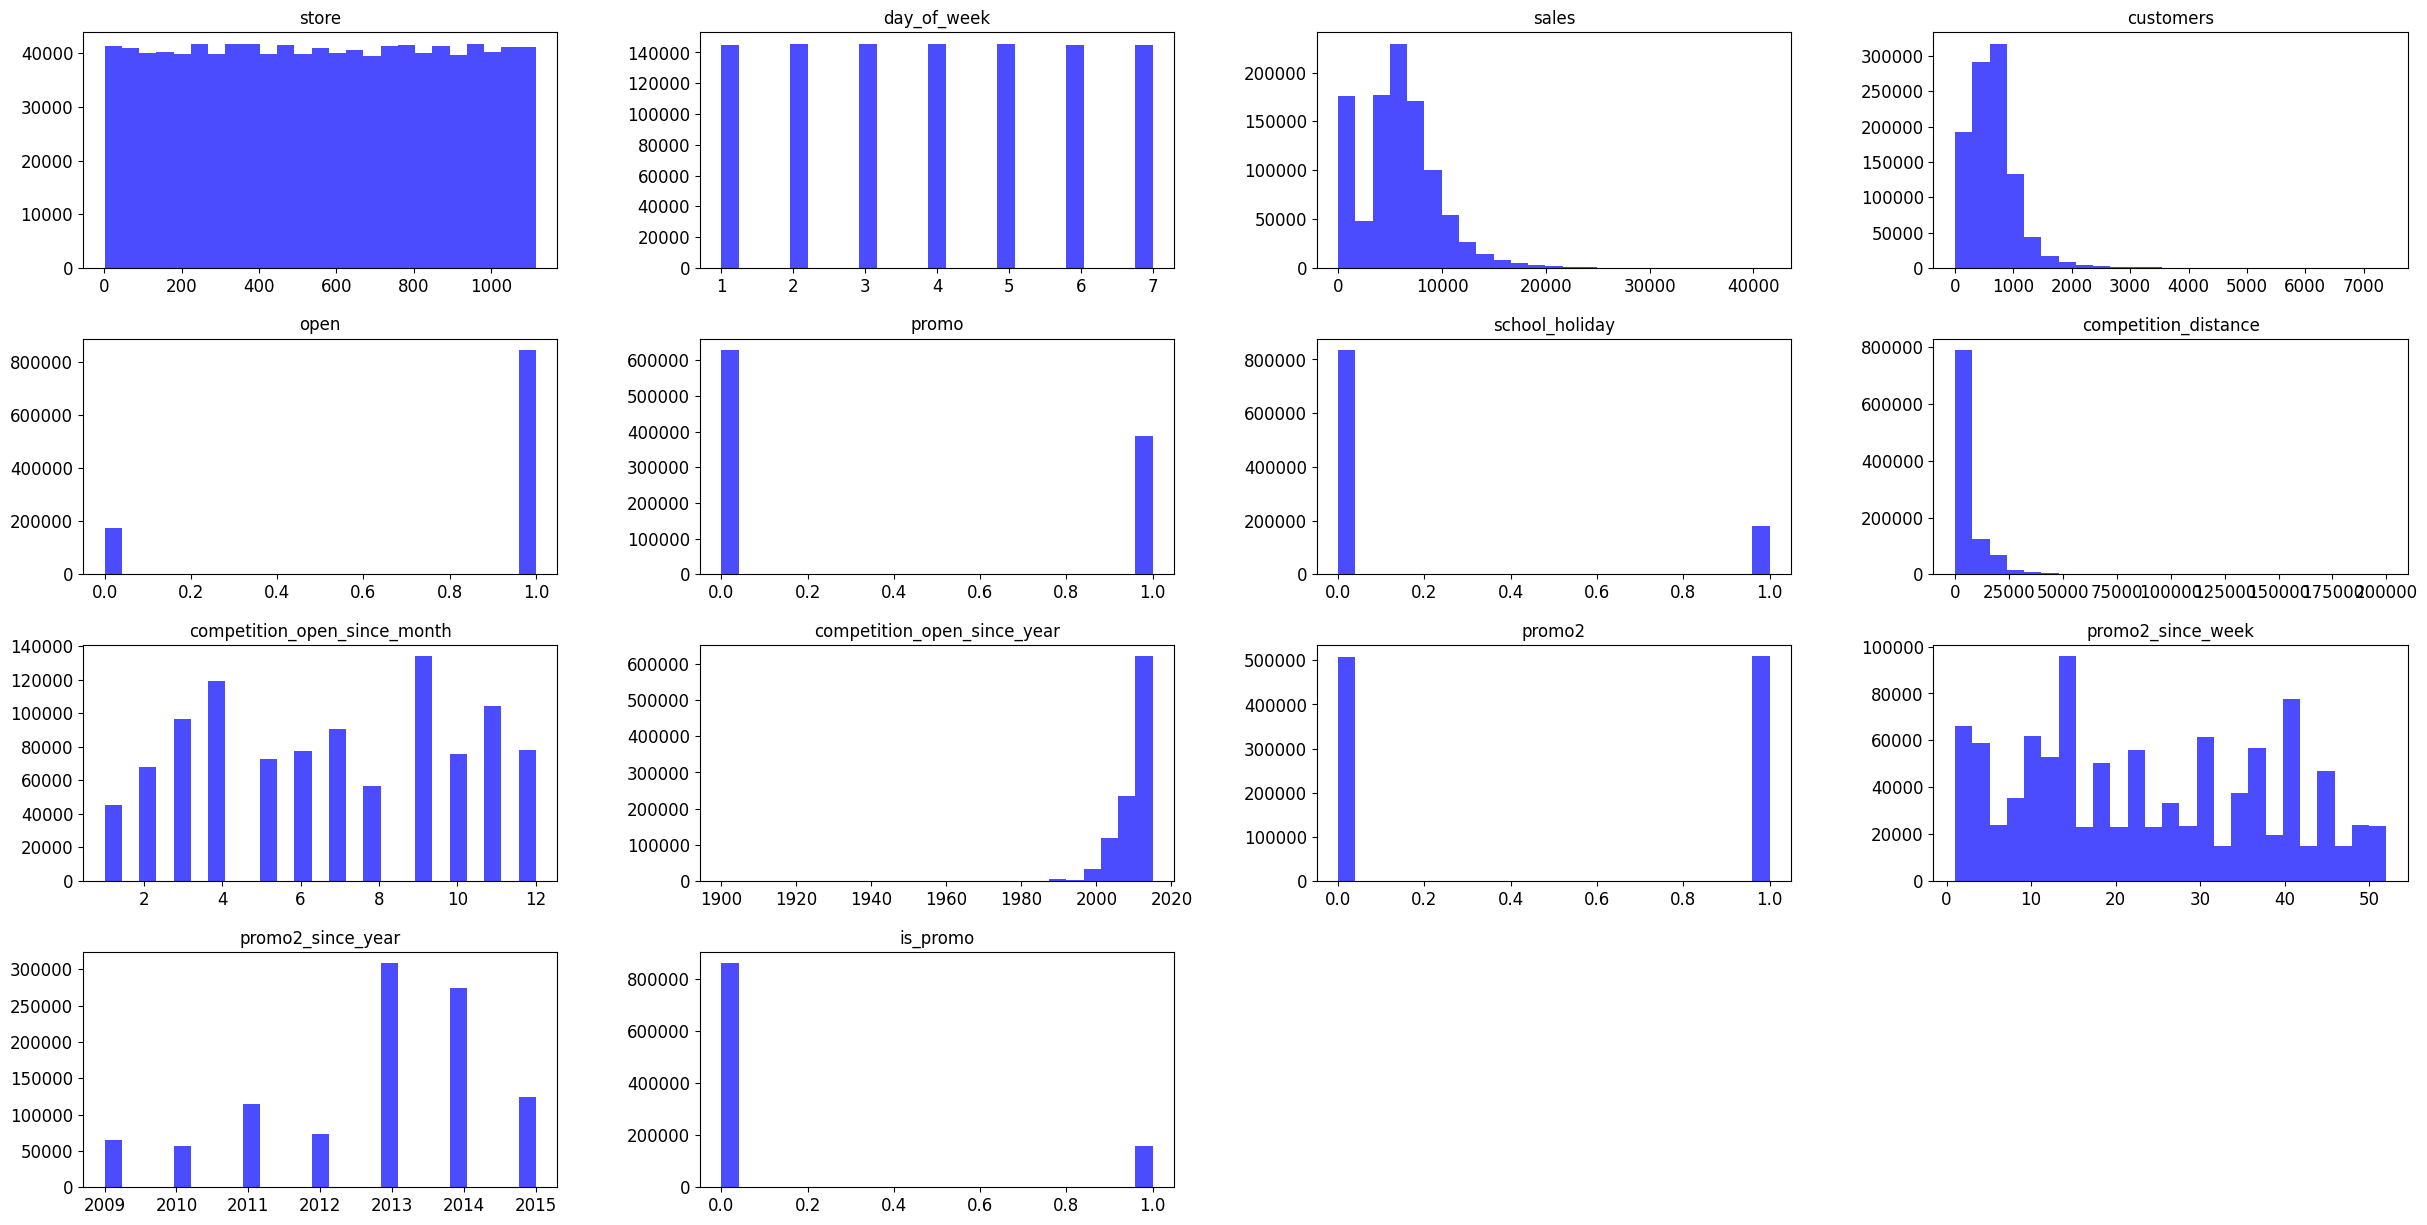

In [36]:
num_attributes.hist(bins=25, figsize=(30, 15), grid=False, xlabelsize=12, ylabelsize=12, alpha=0.7, color='blue')
plt.title("Histograma para Variáveis Numéricas", size=16)
plt.show()

### 4.1.3. Categorical Variables 

In [37]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [38]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         Christmas
Name: state_holiday, dtype: object

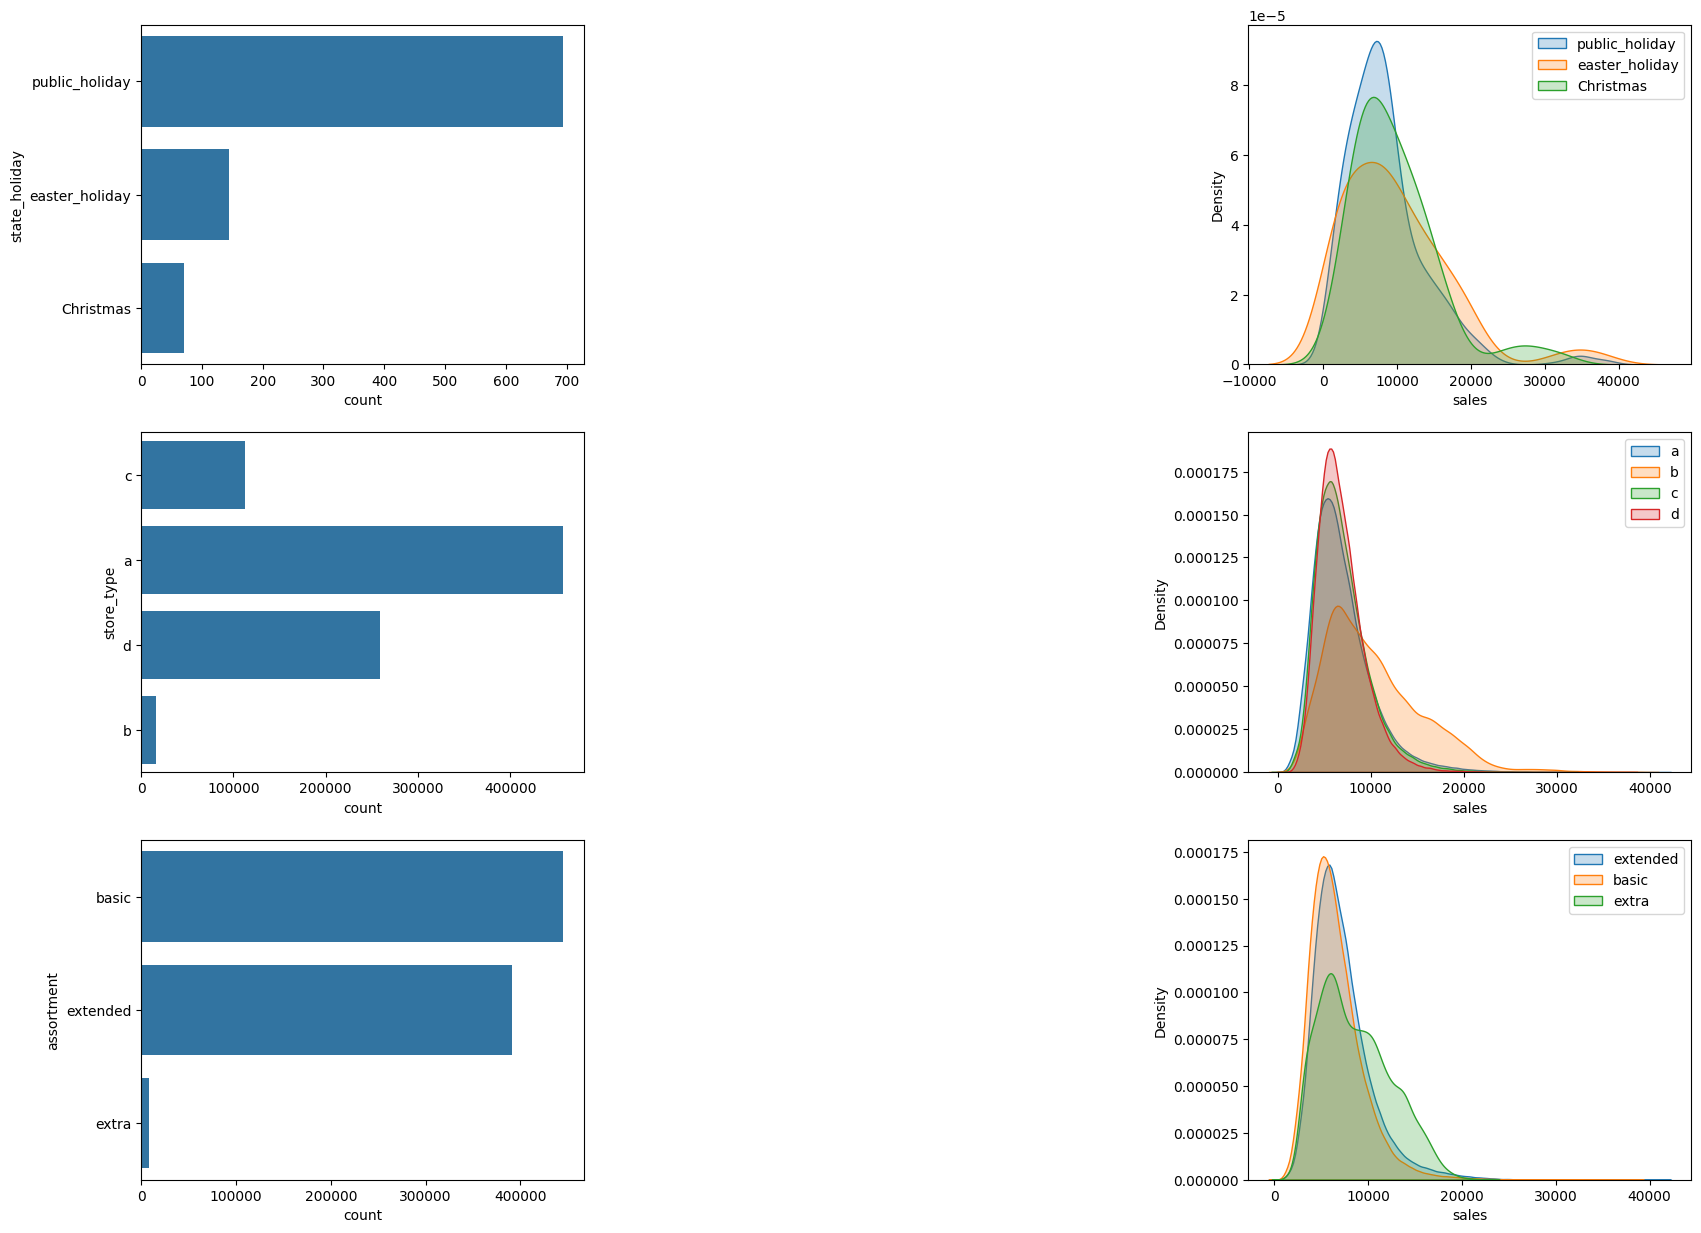

In [39]:
# Setando o tamanho do grafico
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Ajustar a largura entre os subplots
plt.subplots_adjust(wspace=1.5)

# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'], ax=axes[0, 0] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday'] ['sales'], label='public_holiday', fill=True, ax=axes[0, 1] )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday'] ['sales'], label='easter_holiday', fill=True, ax=axes[0, 1] )
sns.kdeplot( df4[df4['state_holiday'] == 'Christmas'] ['sales'], label='Christmas', fill=True, ax=axes[0, 1] )

axes[0, 1].legend()


# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'], ax=axes[1, 0] ) 

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a'] ['sales'], label='a', fill=True, ax=axes[1, 1] )
sns.kdeplot( df4[df4['store_type'] == 'b'] ['sales'], label='b', fill=True, ax=axes[1, 1] )
sns.kdeplot( df4[df4['store_type'] == 'c'] ['sales'], label='c', fill=True, ax=axes[1, 1] )
sns.kdeplot( df4[df4['store_type'] == 'd'] ['sales'], label='d', fill=True, ax=axes[1, 1] )

axes[1, 1].legend()


# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'], ax=axes[2, 0] ) 

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended'] ['sales'], label='extended', fill=True, ax=axes[2, 1],  )
sns.kdeplot( df4[df4['assortment'] == 'basic'] ['sales'], label='basic', fill=True, ax=axes[2, 1] )
sns.kdeplot( df4[df4['assortment'] == 'extra'] ['sales'], label='extra', fill=True, ax=axes[2, 1] )


axes[2, 1].legend()

plt.show()

## 4.2. Bivariate Analysis

### **H1.** Lojas com maior sortimento de produtos, deveriam vender mais.

- **Hipótese Falsa**: Conforme constatado em analise explroatória, lojas com maior sortimento vendem menos 



<Axes: xlabel='year_week'>

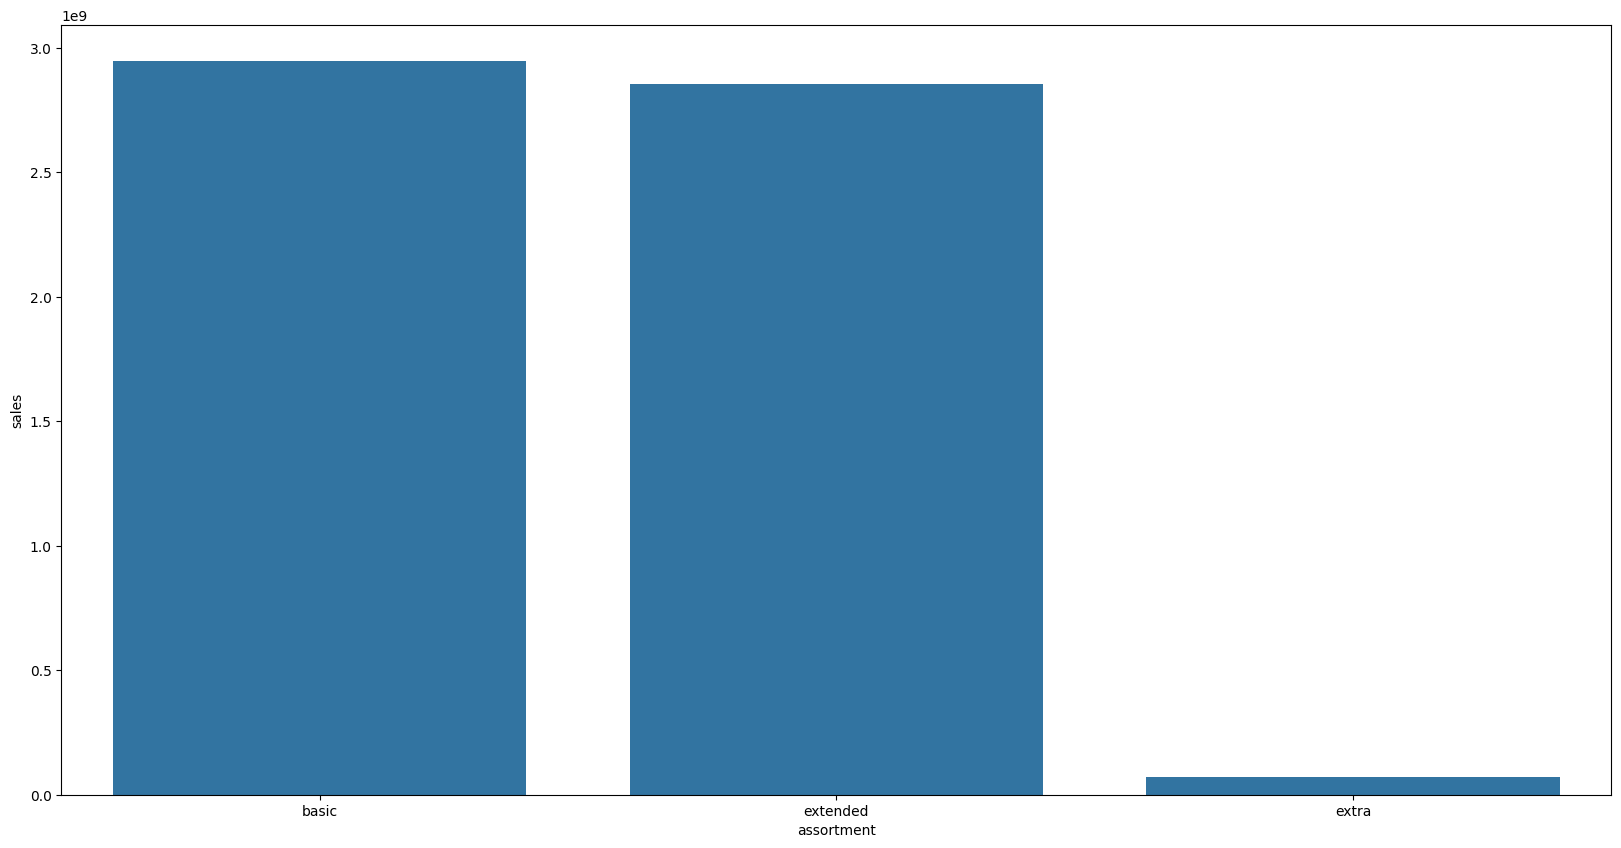

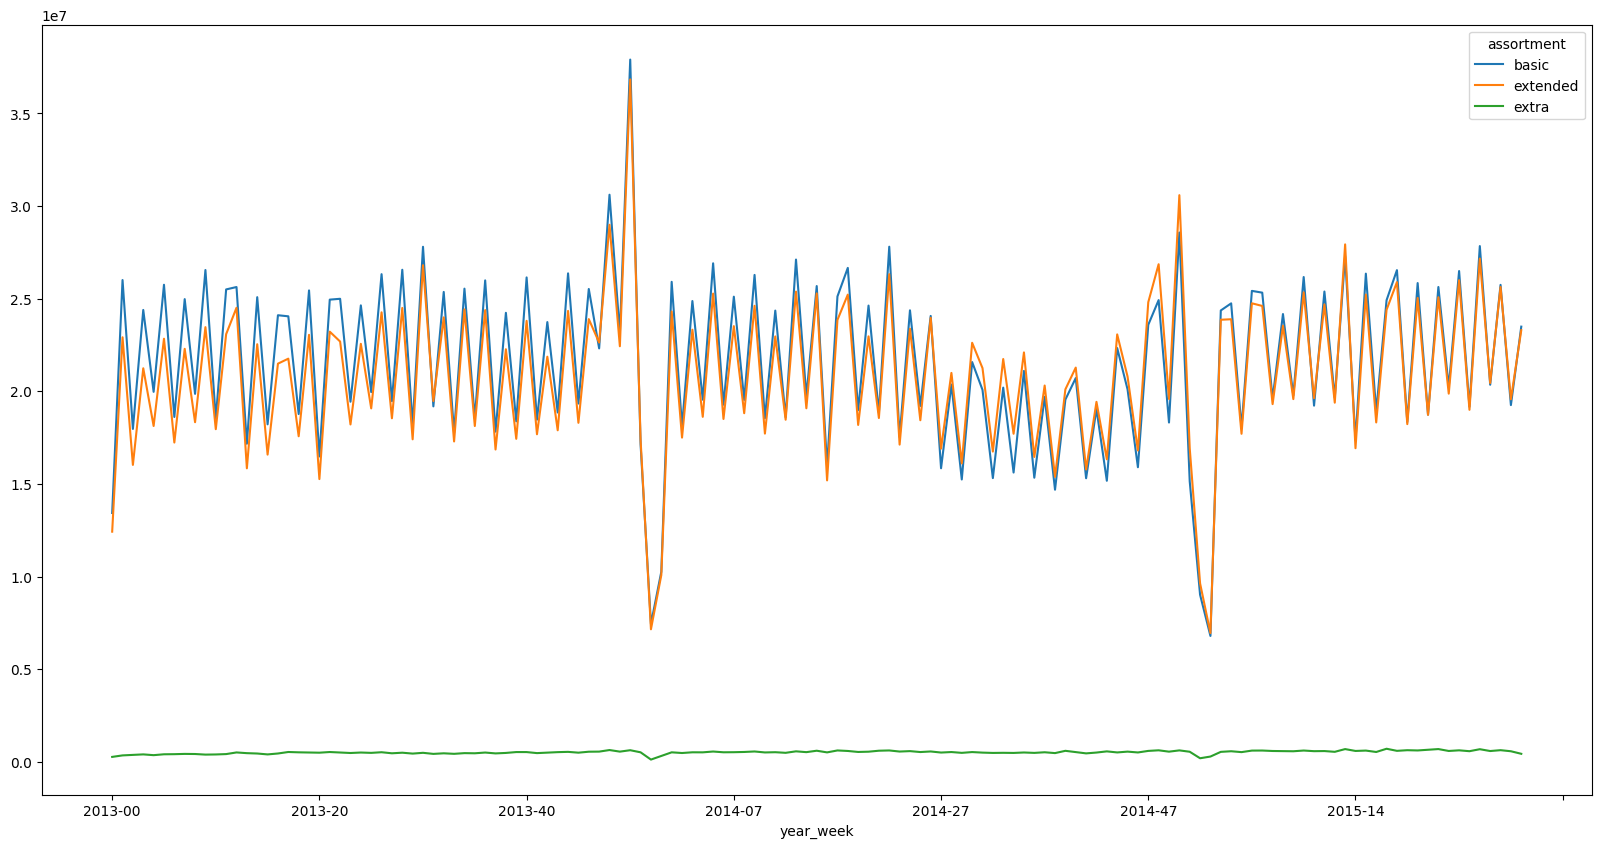

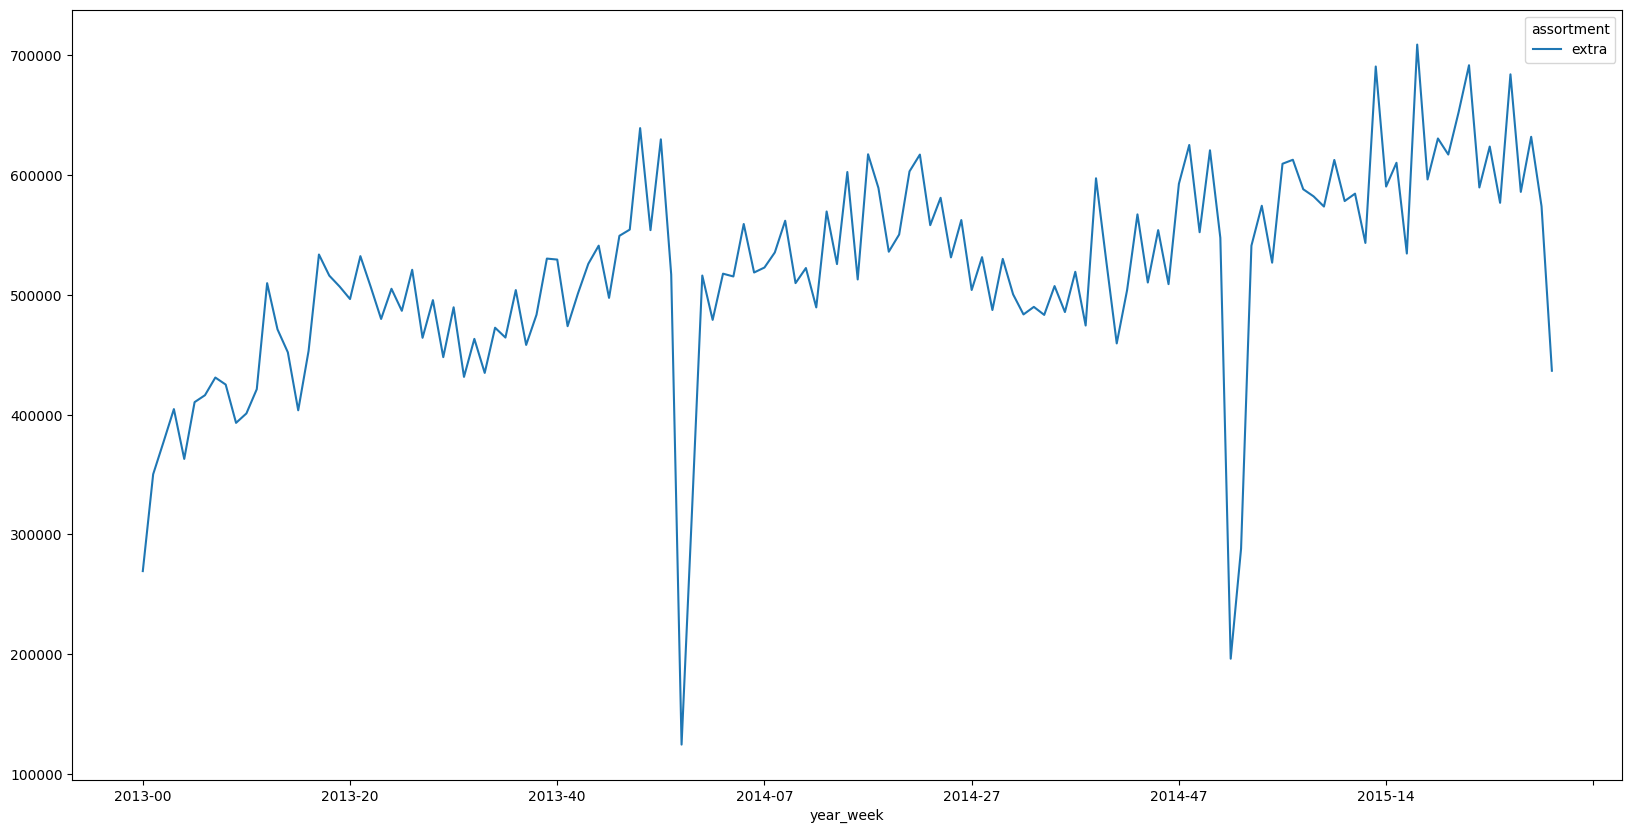

In [40]:
plt.figure(figsize=( 20, 10) )
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# Fazendo a comparação de vendas baseado nos anos/semanas
aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index= 'year_week', columns='assortment', values='sales' ).plot( figsize=(20, 10) )

# Plotando o assortment tipo extra para verificar se existe alguma linearidade em seu comportamento 
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index= 'year_week', columns='assortment', values='sales' ).plot( figsize=(20, 10) )


### **H2.** Lojas com concorrentes mais proximos deveriam vender menos
- **Hipótese Falsa**: Lojas com competidores mais proximos vendem mais



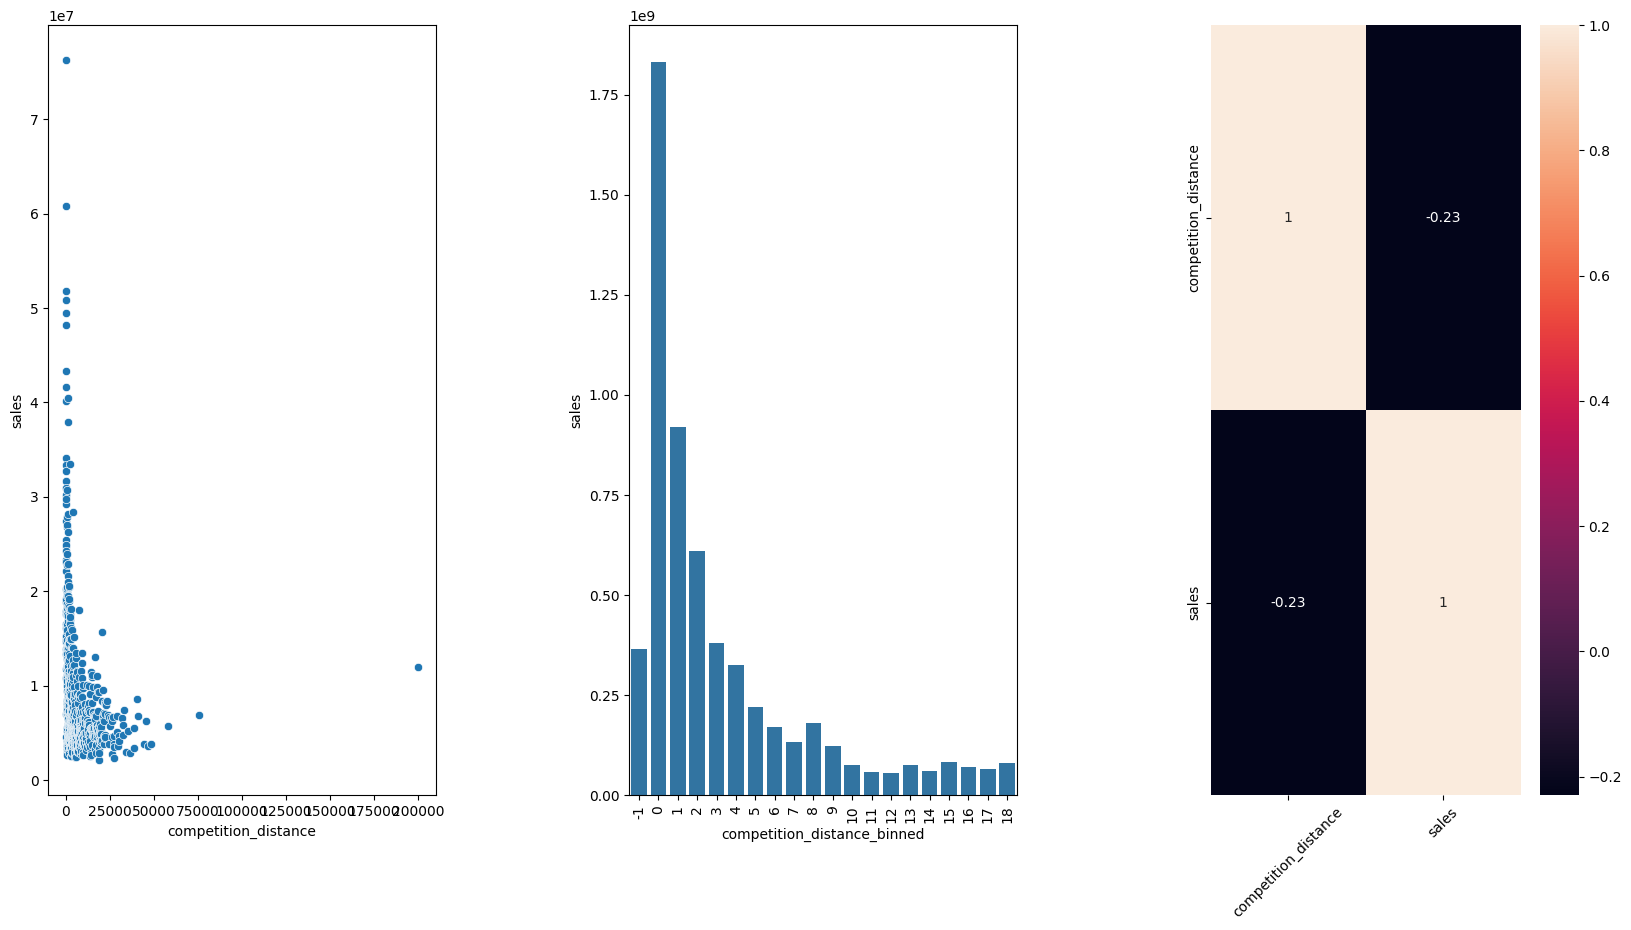

In [41]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').sum().reset_index()

# Criando a figura e os eixos
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1, ax=axes[0] );

# Plotando o Bar Chart
plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
#aux2['competition_distance_binned'] = pd.cut(aux2.index, bins=bins, right=False)
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins ).cat.codes
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks(rotation=90)

# Plotando um Heat Map
plt.subplot( 1, 3, 3 )
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True, ax=axes[2])



plt.xticks(rotation=45)  # Gire as labels do eixo x em 45 graus
plt.subplots_adjust(wspace=0.5)
plt.show()


### **H3.** Lojas com concorrentes a mais tempo deveriam vender mais.
- **Hipótese Falsa:** Lojas com competidores a mais tempo vendem menos.

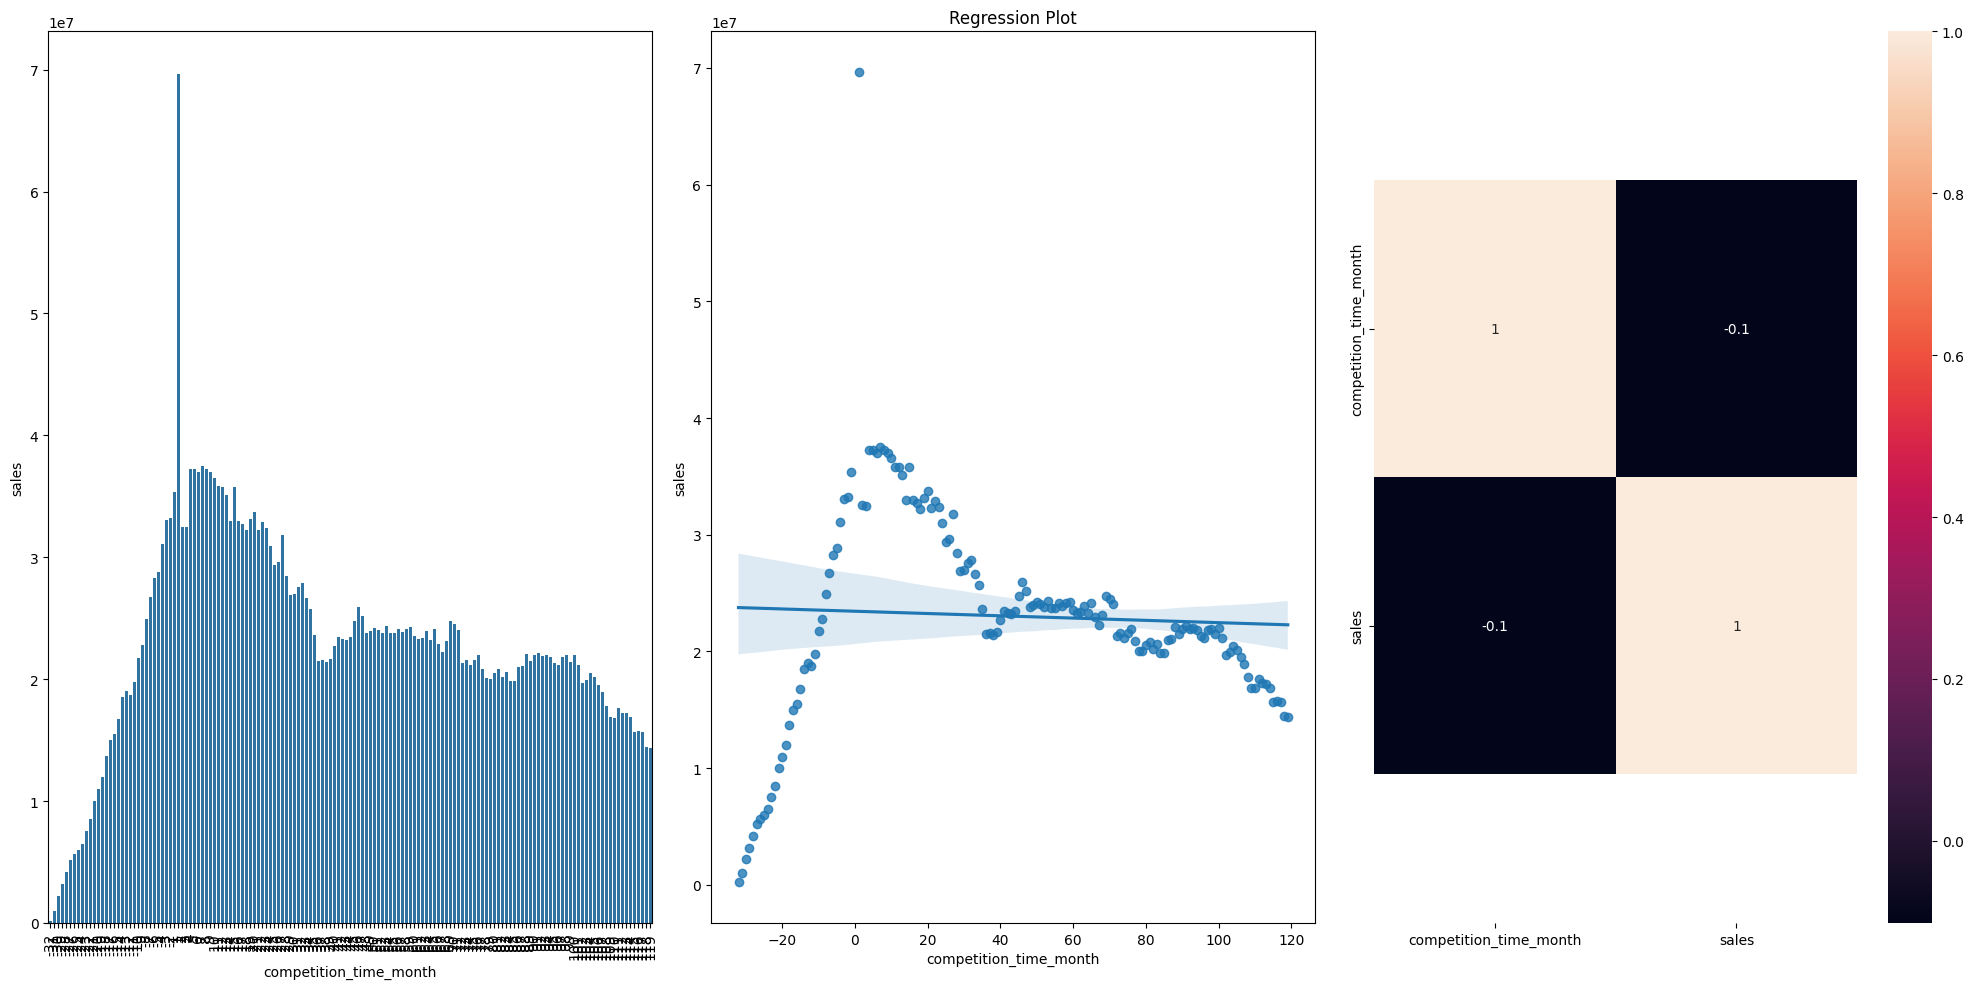

In [42]:
# Ajustando o tamanho das plotagens
plt.figure(figsize=(20, 10))

# Bar Chart
plt.subplot( 1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )] 
sns.barplot(x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Regression Plot
plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2 );
plt.title('Regression Plot')

# Heat Map 
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True )
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

plt.tight_layout()
plt.show()



### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

- **Hipótese Falsa** Lojas com promomoções ativas por mais tempo tendem a vender menos conforme os dias da promoção aumentam.

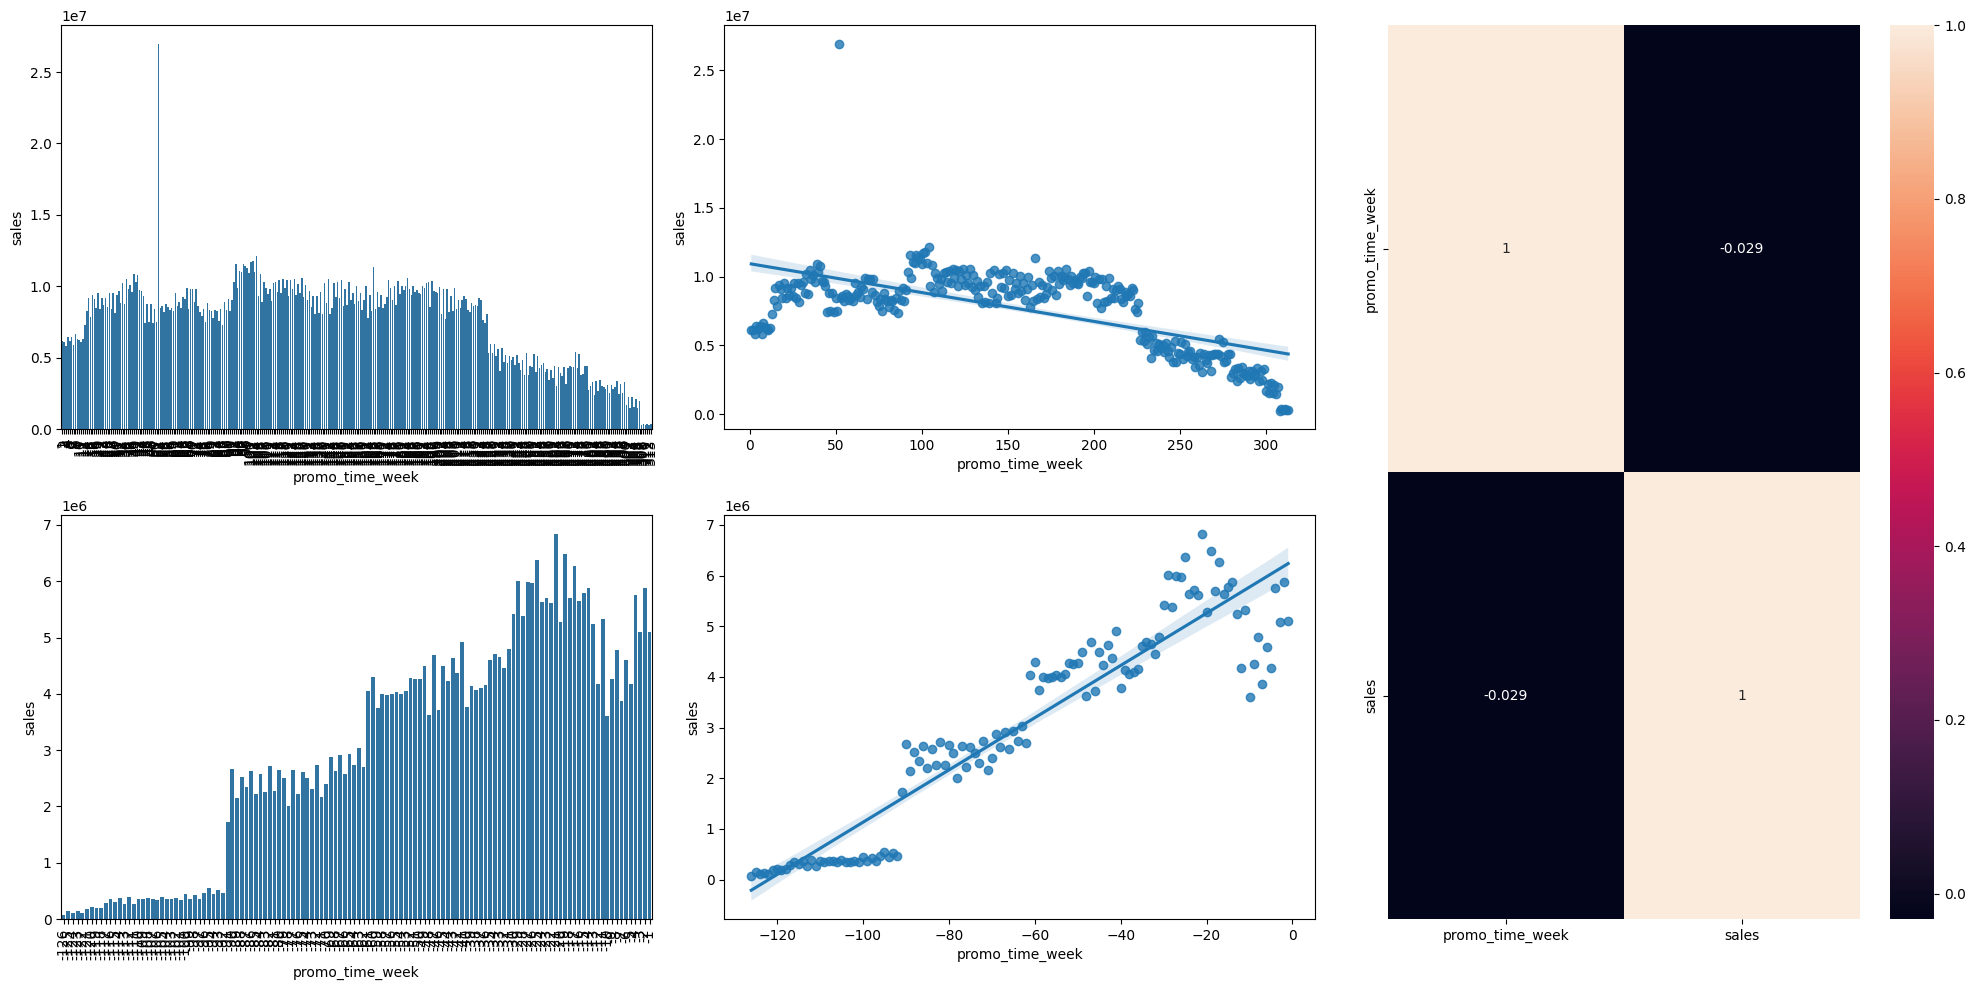

In [43]:
plt.figure(figsize=(20, 10))
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()
grid = GridSpec( 2, 3 )

# Periodo extendido promo 
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 )

# Red Plot Graph extended promo 
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# Periodo regular promo 
plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 )

# Red Plot Graph regular promo 
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



plt.tight_layout()
plt.show()

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

- **Hipótese Falsa**: Lojas com promoções consecutivas vendem menos.

In [44]:
#df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index()

#aux1 = aux1[aux1['promo']] 
#sns.barplot( x='promo_time_week', y='sales', data=aux1 );
#plt.xticks( rotation=90 )

<Figure size 2000x1500 with 0 Axes>

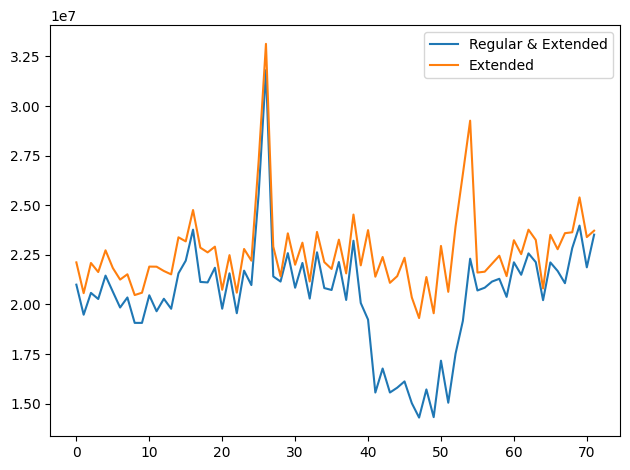

In [45]:
plt.figure(figsize=(20, 15))


# Regular promo time
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )] [['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# Extended promo time
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )] [['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular & Extended', 'Extended'] );
plt.tight_layout()
plt.show()

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.

- **Hipótese Falsa**: Lojas abertas durante o feriado de natal vendem menos.










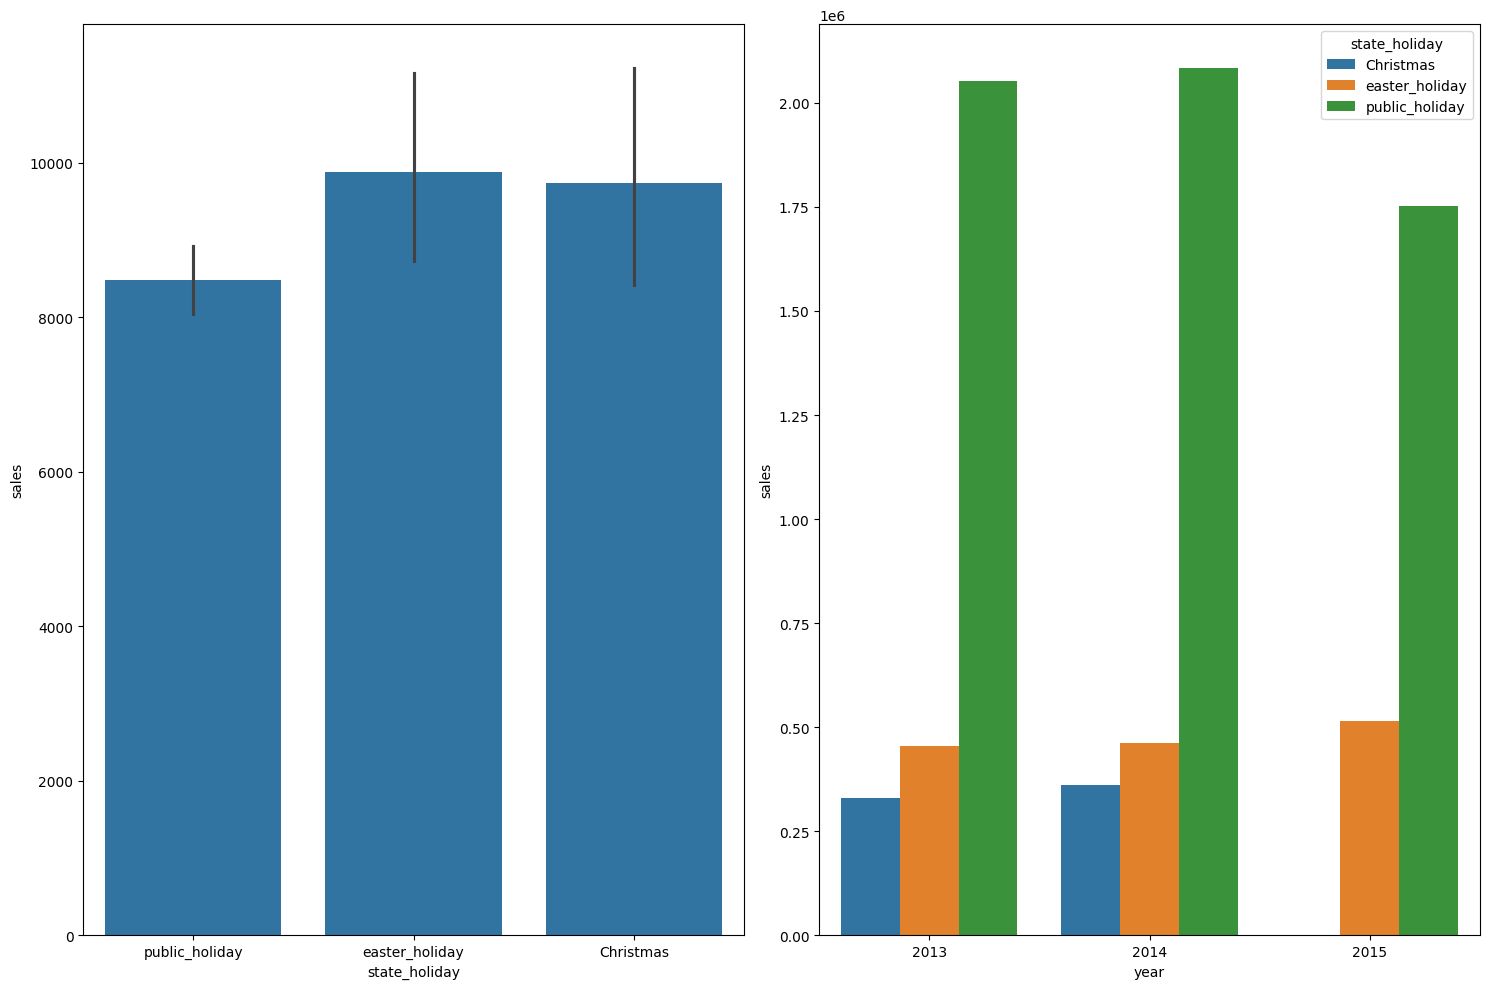

In [46]:
plt.figure(figsize=(15, 10))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux)

# Quanto foi vendido no feriado ao longo dos anos 
plt.subplot( 1, 2, 2 )
aux2 = aux[['year','state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2)

plt.tight_layout()
plt.show()

### **H8.** Lojas deveriam vender mais ao longo dos anos. 

- **Hipótese Falsa**: As Lojas tendem a vender menos ao longo dos anos.

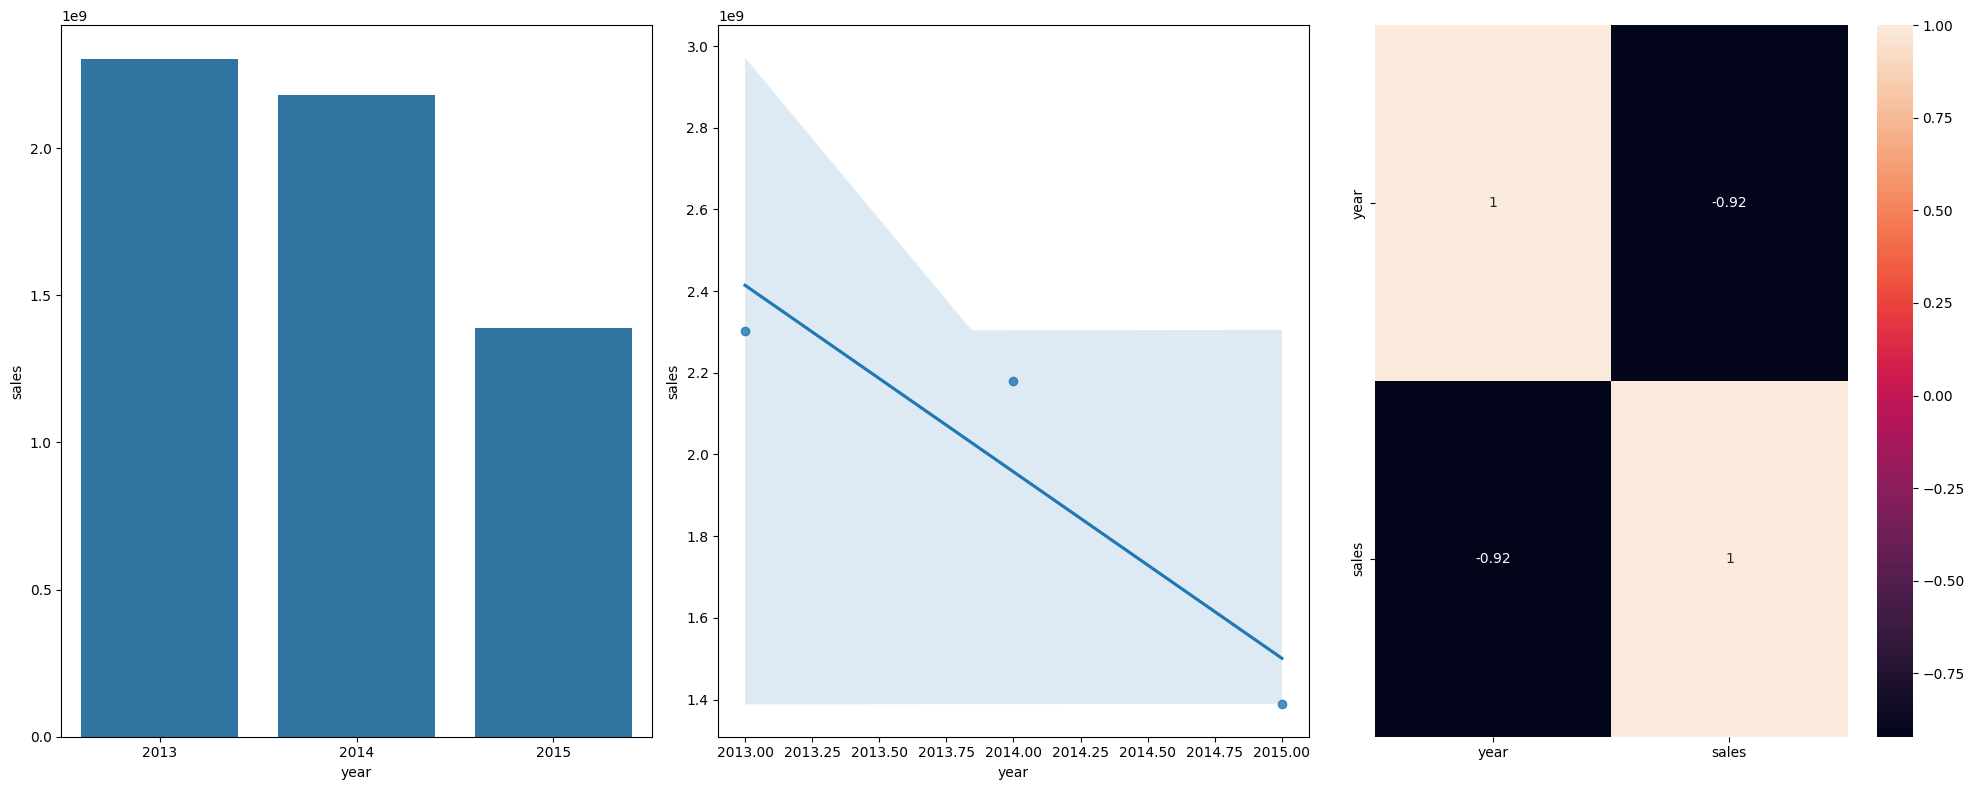

In [47]:
plt.figure( figsize=( 20, 8 ) )

plt.subplot( 1, 3, 1 )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

# Verificando a tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

# Heat Map Corr
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()
plt.show()


### **H9.** Lojas deveriam vender mais no segundo semestre do ano. 

- **Hipótese Falsa** As lojas tendem a vender menos no segundo semestre do ano.

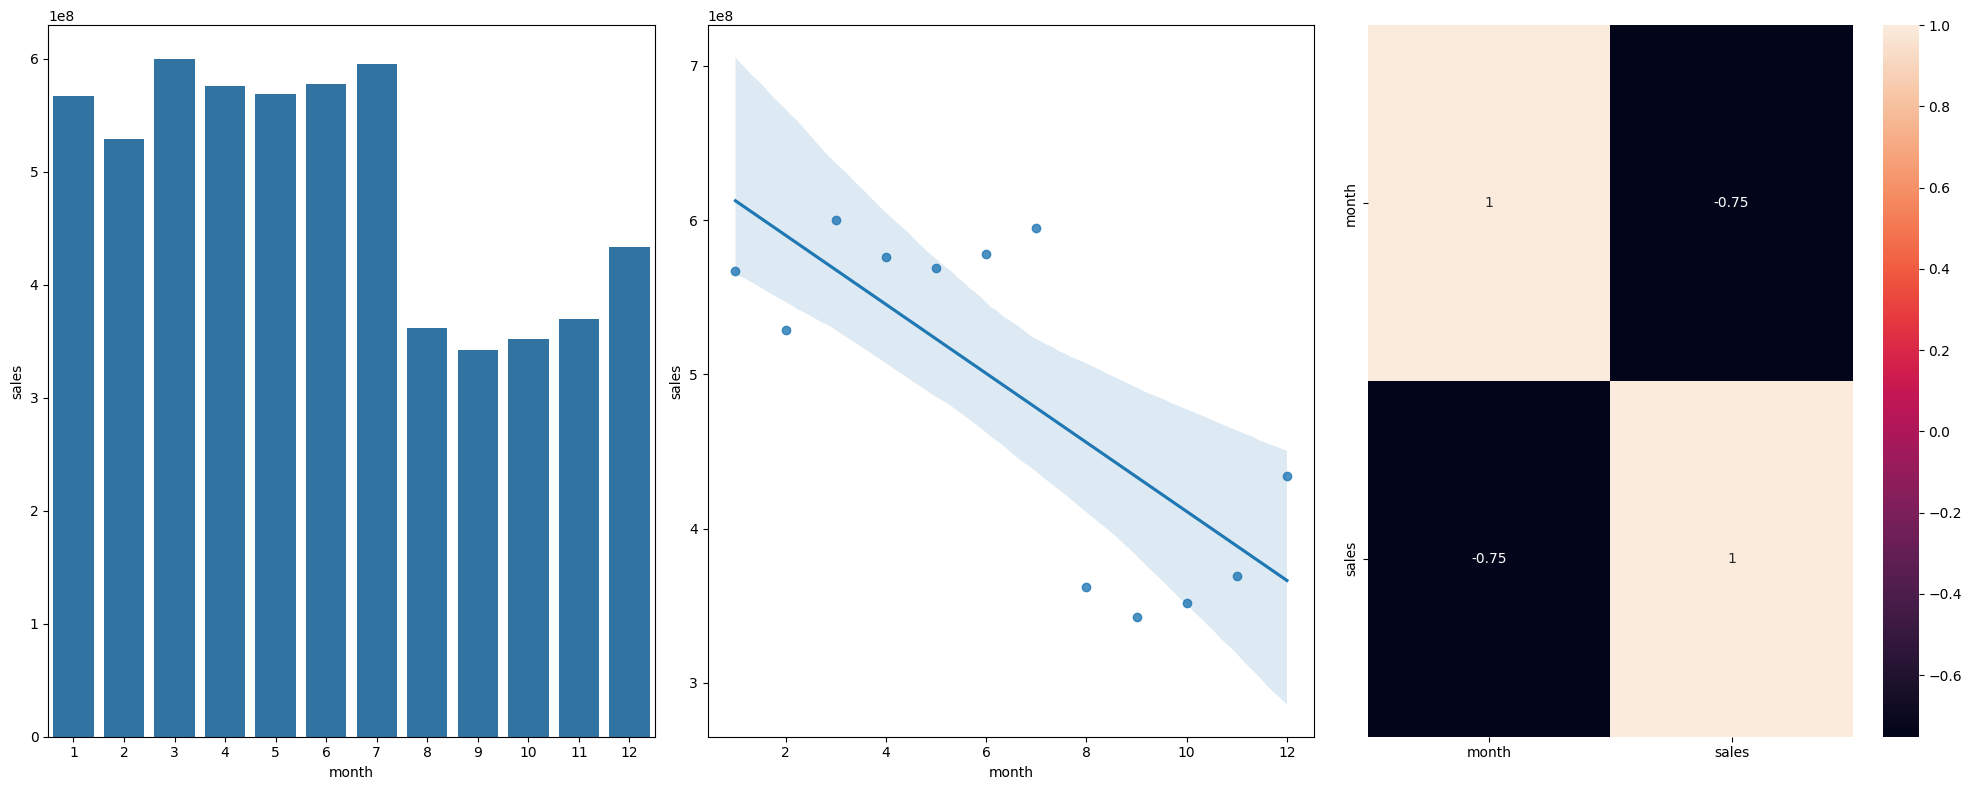

In [48]:
plt.figure( figsize=( 20, 8 ) )

plt.subplot( 1, 3, 1 )
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1 );

# Verificando a tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

# Heat Map Corr
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()
plt.show()

### **H10.** Lojas Deveriam vender mais depois do dia 10 de cada mês

- **Hipótese Verdadeira**: As lojas tendem a vender mais após o décimo dia do mês.

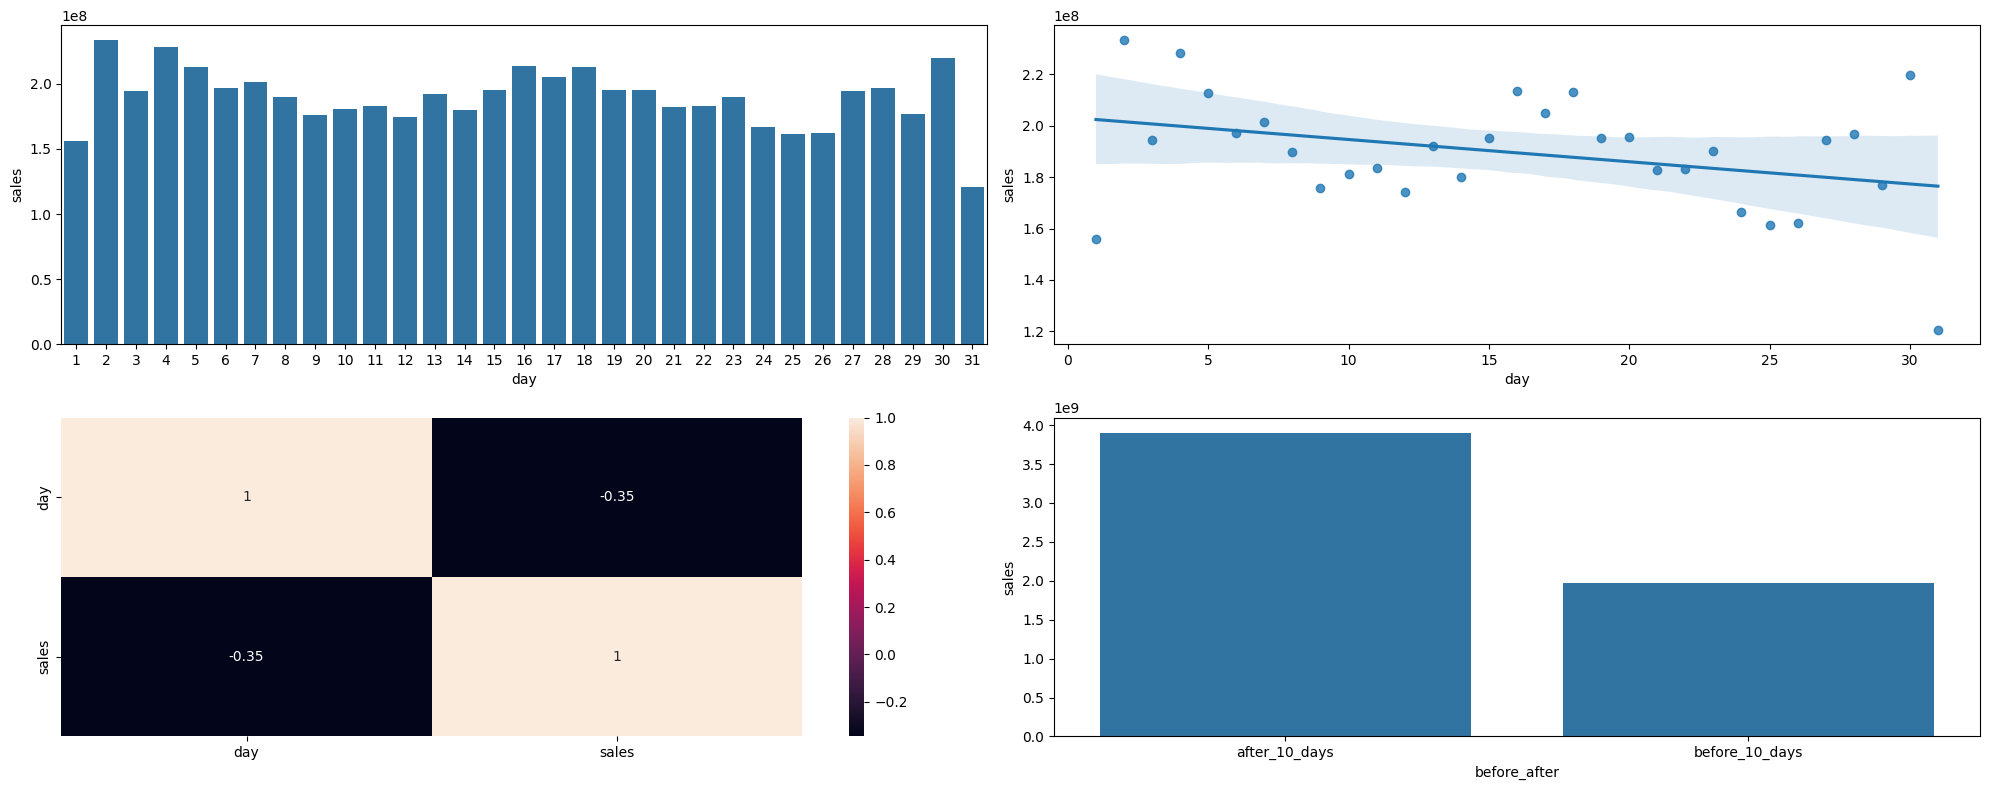

In [49]:
plt.figure( figsize=( 20, 8 ) )

plt.subplot( 2, 2, 1 )
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1 );

# Verificando a tendencia
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

# Heat Map Corr
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

# Vendas antes e depois do ida 10
plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 )


plt.tight_layout()
plt.show()

### **H11.** Lojas Deveriam vender menos aos finais de semana.

- **Hipótese Verdadeira**: As Lojas tendem a vender menos nos Finais De Semana 

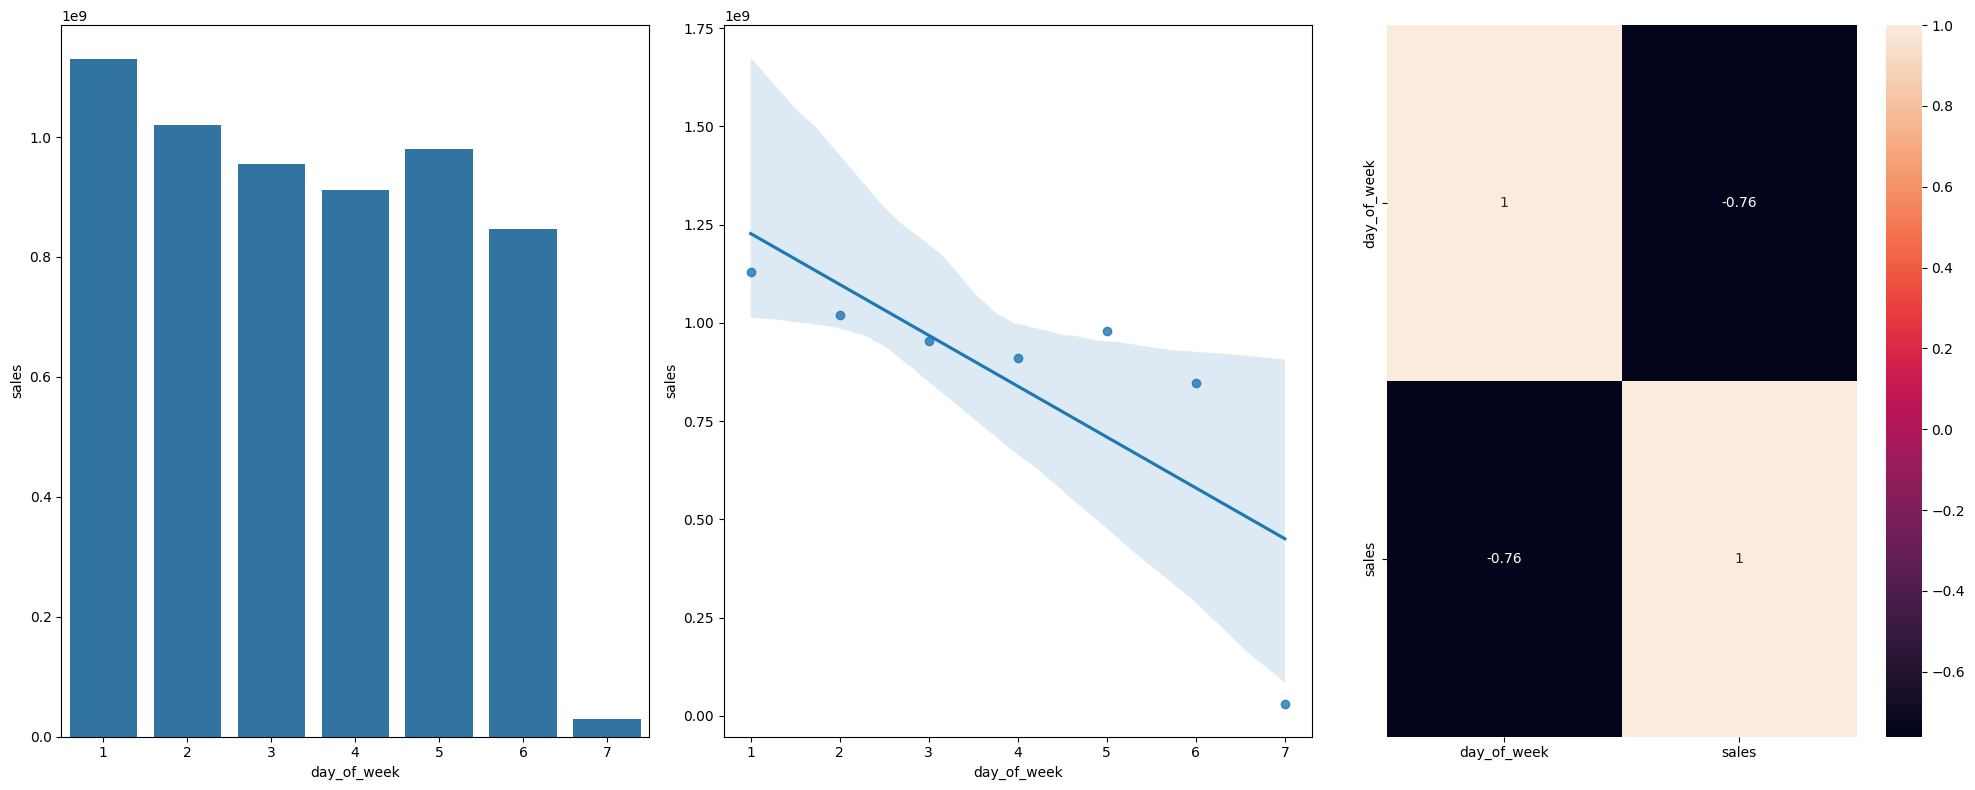

In [50]:
plt.figure( figsize=( 20, 8 ) )

plt.subplot( 1, 3, 1 )
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1 );

# Verificando a tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

# Heat Map Corr
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()
plt.show()

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

-**Hipótese Verdadeira**: As lojas vendem menos nos feriados escolares, exceto os meses de Julho e Agosto. 

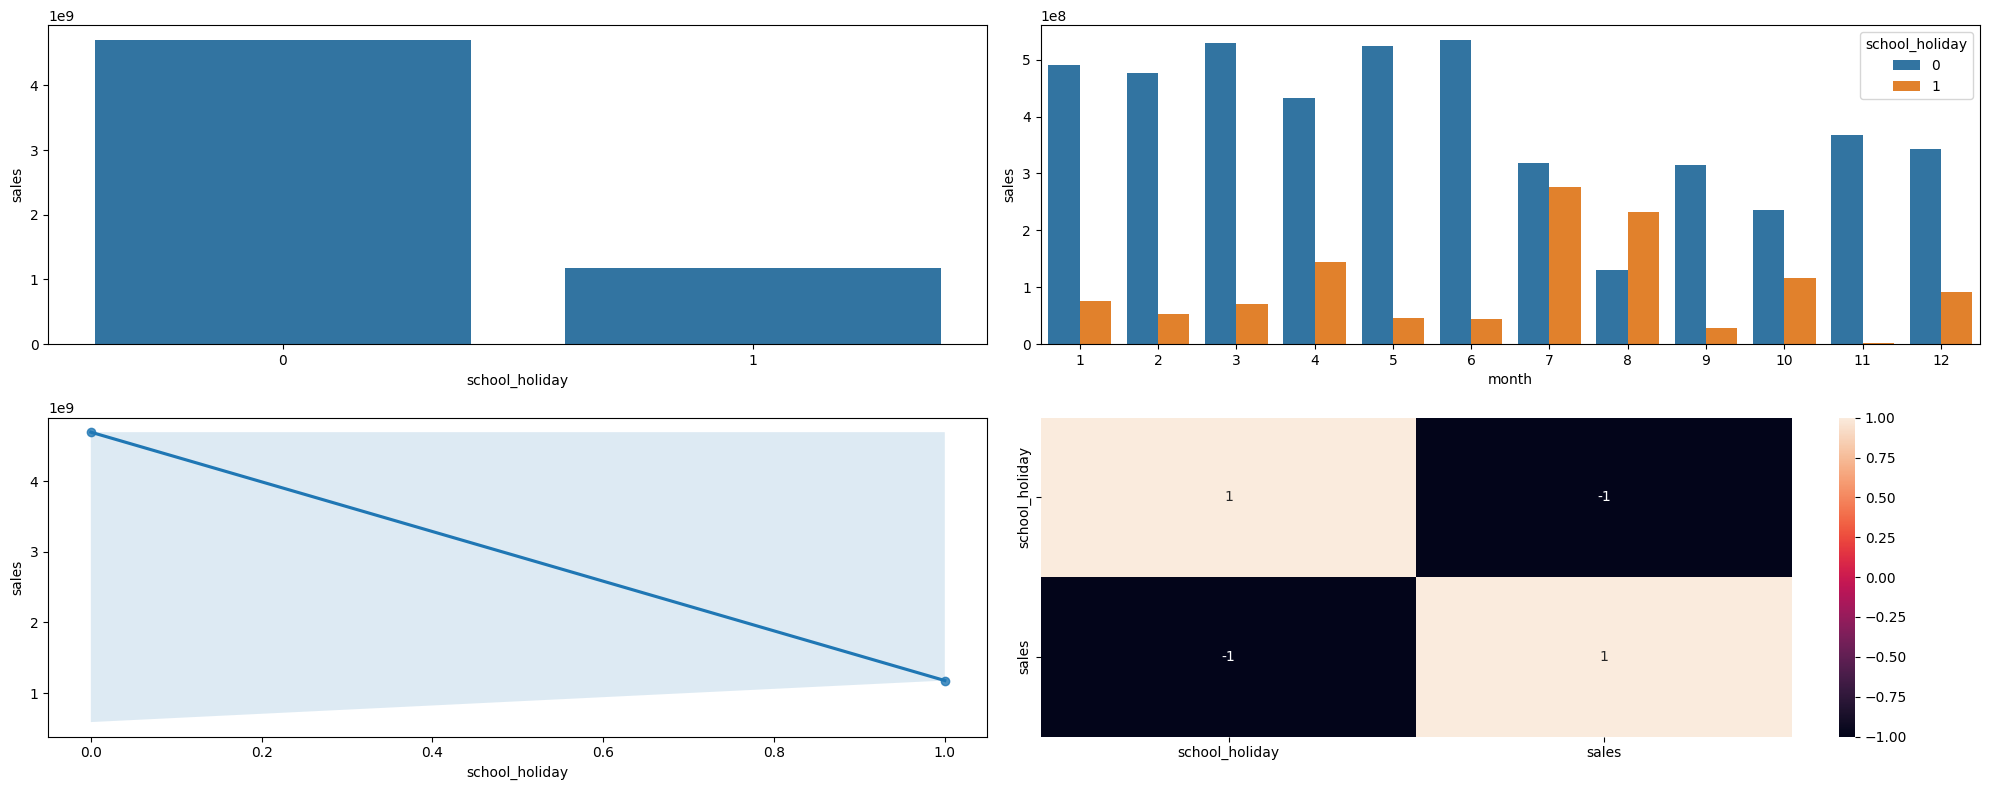

In [51]:
plt.figure( figsize=( 20, 8 ) )

# Bar Plot
plt.subplot( 2, 2, 1 )
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

# Bar Plot
plt.subplot( 2, 2, 2 )
aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

# Verificando a tendencia
plt.subplot( 2, 2, 3 )
sns.regplot( x='school_holiday', y='sales', data=aux1 );

# Heat Map Corr
plt.subplot( 2, 2, 4 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()
plt.show()

### 4.2.1. Resumo das Hipóteses

In [52]:
from tabulate import tabulate

In [53]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Multivariate analysis

### 4.3.1. Numerical Attributes

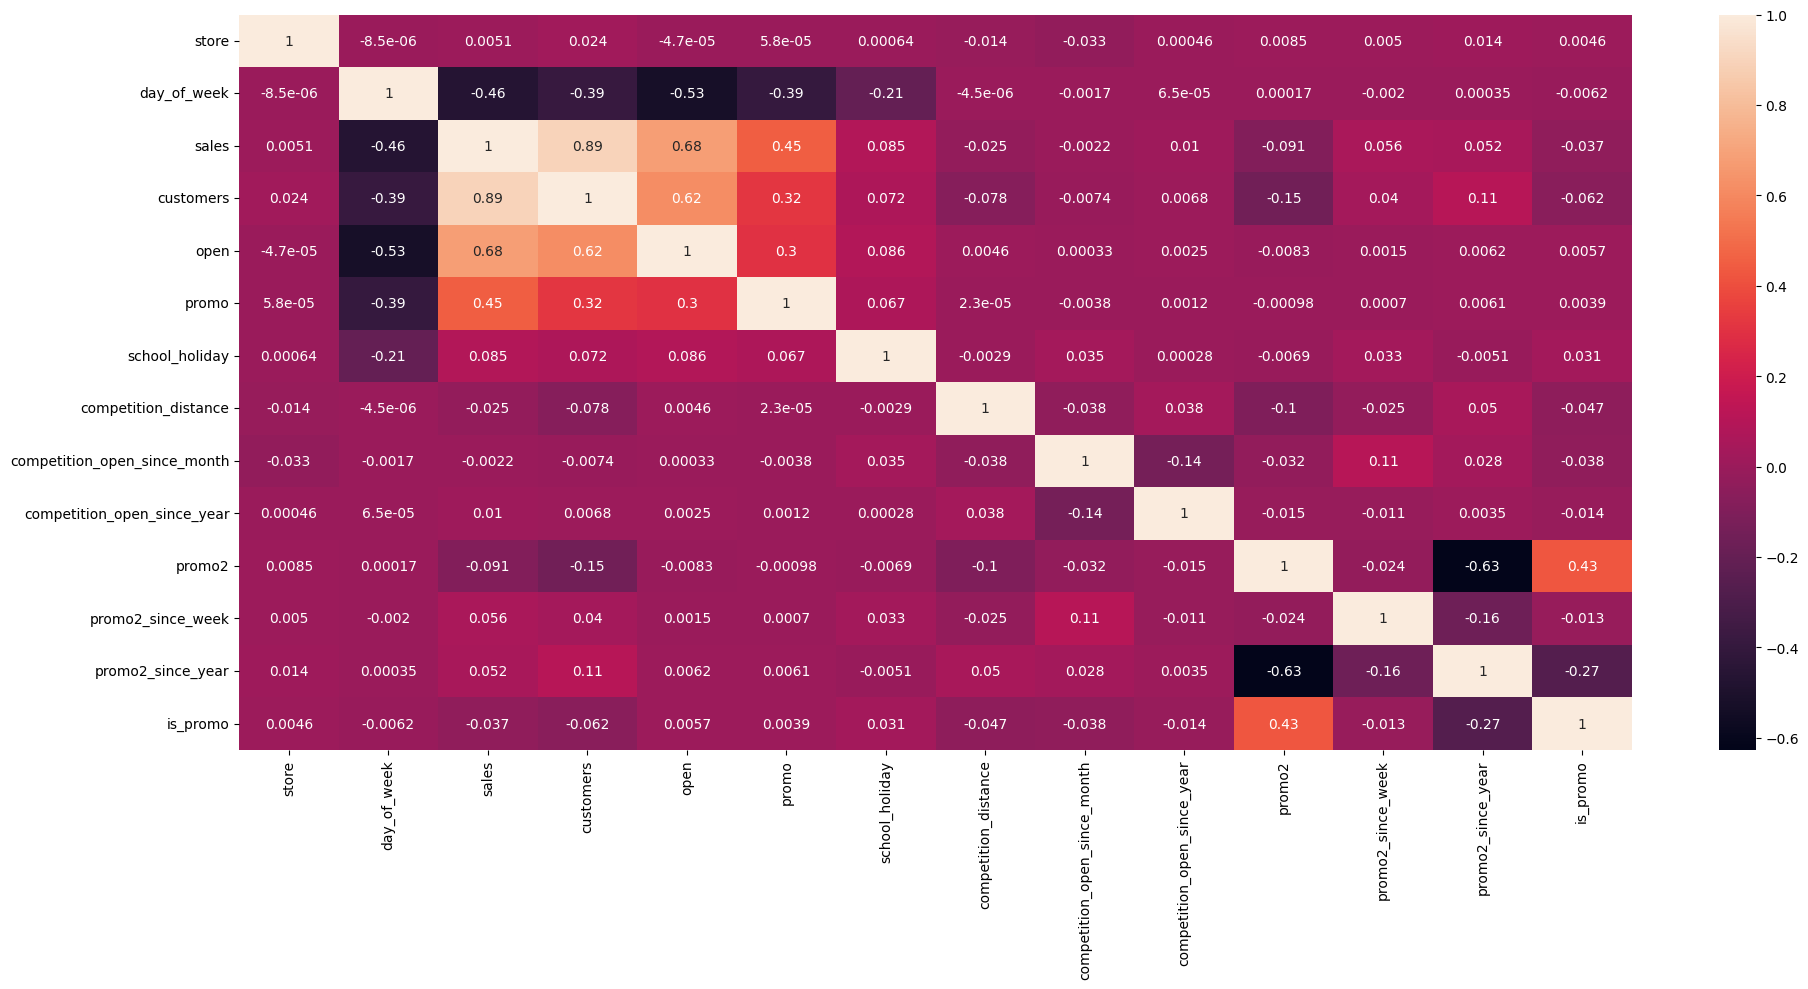

In [54]:
plt.figure(figsize=( 20, 10) )
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True )
plt.tight_layout()
plt.show()

### 4.3.2. Categorical Attributes

In [55]:
# Only Categorical Data
a = df4.select_dtypes( include='object' )

# Calculate Cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final DataSet
d = pd.DataFrame( { 'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

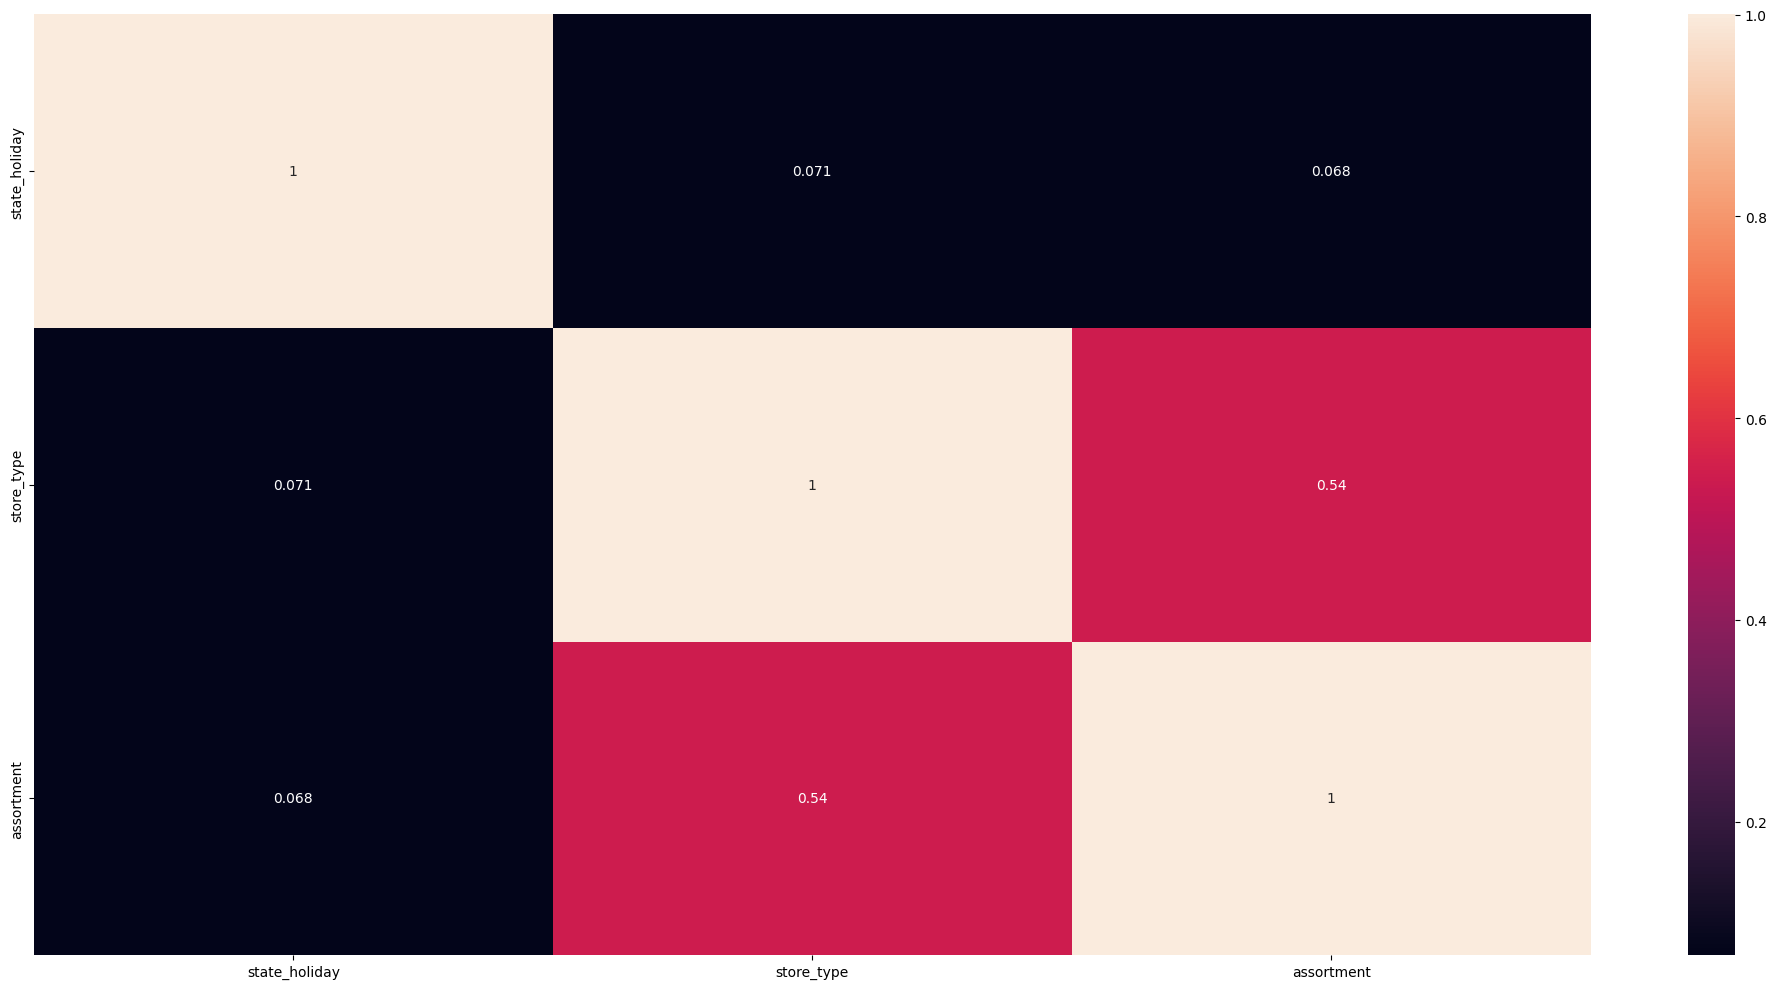

In [56]:
plt.figure(figsize=( 20, 10) )
sns.heatmap( d, annot=True )
plt.tight_layout()
plt.show()

# 5.0. Data Preparation 

In [57]:
df5 = df4.copy()

## 5.1. Normalization 

## 5.2. Rescaling

In [58]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform ( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform ( df5[['year']].values )



## 5.3. Transformation 

### 5.3.1 Encoding 

In [59]:
# state_holiday - One Hot Encoding 
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] ) # Primeiro State Holiday é o nome que quero chamar a coluna e o segundo é a coluna que quero pegar 

# store_type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment -  Ordinal Encoding 
assortment_dict = { 'basic': 1,
                   'extra': 2,
                   'extended': 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation 

In [60]:
df5['sales'] = np.log1p( df5['sales'] )

/tmp/ipykernel_34127/1280518142.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['sales'] )


<Axes: xlabel='sales', ylabel='Density'>

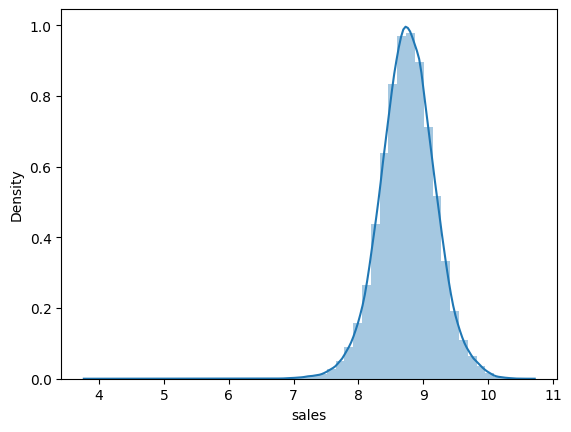

In [61]:
sns.distplot( df5['sales'] )

### 5.3.3. Nature Tranformation 

In [62]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )

In [63]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. Feature Selection 

In [64]:
df6 = df5.copy()

In [65]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 6.1. Split DataFrame into training and test DataSet

-  Removendo as Colunas originais onde foi derivado outras variaveis

In [66]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week','promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [67]:
df6[['store', 'date' ]].groupby( 'store' ).max().reset_index()['date'][0] - dt.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [68]:
# Training
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales'] 

# Test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales'] 

print('Training Min Date: {}'.format( X_train['date'].min() ) )
print('Training Max Date: {}'.format( X_train['date'].max() ) )

print('\nTest Min Date: {}'.format( X_test['date'].min() ) )
print('Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [69]:
# Training DataSet For Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# Define Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1 )

# Define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features From Boruta 

In [70]:
#cols_selected = boruta.support_.tolist()

# Best Features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not Selected Boruta
#cols_not_selected_boruta =  list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Features Selection 

In [71]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos' 
 ]

# Columns to add
feat_to_add = ['date', 'sales']

# Final Feature
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add ) # Colocando no DF as colunas Date e sales para executar o cross validation 




# 7.0. Machine Learning Modelling


In [72]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation 
x_training = X_train[ cols_selected_boruta_full ] # são as variaveis relevantes do conjunto de dados + o date e sales para fazer a separação p cross validation.

## 7.1. Average Model

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales' ]].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model 

In [74]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance 
lr_result = ml_error( 'Lienar Regression', np.expm1( y_test ), np.expm1( yhat_lr) )

lr_result

,Model Name,MAE,MAPE,RMSE
0,Lienar Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [75]:
cv_lr_result = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

cv_lr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [76]:
# Model
lrr = Lasso( alpha=0.0000001 ).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict( x_test )

# Performance 
lrr_result = ml_error( 'Lienar Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr) )

lrr_result

/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.629e+04, tolerance: 1.455e+01
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE,MAPE,RMSE
0,Lienar Regression - Lasso,1867.26137,0.292728,2671.379404


### 7.3.1. Linear Regression Lasso Model - Cross Validation

In [77]:
cv_lrr_result = cross_validation( x_training, 5, 'lasso', lrr, verbose=False )

cv_lrr_result

/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.343e+04, tolerance: 1.117e+01
  model = cd_fast.enet_coordinate_descent(
/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.619e+04, tolerance: 1.194e+01
  model = cd_fast.enet_coordinate_descent(
/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,lasso,2081.76 +/- 295.65,0.3 +/- 0.02,2952.57 +/- 468.33


## 7.4. Random Forest Regressor 

In [78]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance 
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf) )

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.098387,0.099882,1009.869873


### 7.4.1. Random Forest Regressor Model - Cross Validation

In [79]:
cv_rf_result = cross_validation( x_training, 5, 'Random Forest', rf, verbose=False )

cv_rf_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.47 +/- 218.61,0.12 +/- 0.02,1257.22 +/- 319.82


## 7.5. XGBoost Regressor 

In [80]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10,
                              subsample=0.7, 
                              colsample_bytee=0.9 
                              ).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance 
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_result

/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.787403,0.251783,2478.398238


### 7.5.1. XGBoost Regressor Model - Cross Validation

In [81]:
cv_xgb_result = cross_validation( x_training, 5, 'XGBoost', model_xgb, verbose=True )

cv_xgb_result


 KFold Number: 5


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



 KFold Number: 4


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



 KFold Number: 3


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



 KFold Number: 2


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



 KFold Number: 1


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1862.62 +/- 294.29,0.25 +/- 0.01,2688.95 +/- 434.78


## 7.6.Model's Performance Comparision  

### 7.6.1. Single Performance

In [82]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )



,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.098387,0.099882,1009.869873
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1695.787403,0.251783,2478.398238
0,Lienar Regression,1867.089774,0.292694,2671.049215
0,Lienar Regression - Lasso,1867.261370,0.292728,2671.379404


### 7.6.2. Real Performance - Cross Validation 

In [83]:
modelling_result_cv = pd.concat( [cv_lr_result, cv_lrr_result, cv_rf_result, cv_xgb_result] )
modelling_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,lasso,2081.76 +/- 295.65,0.3 +/- 0.02,2952.57 +/- 468.33
0,Random Forest,837.47 +/- 218.61,0.12 +/- 0.02,1257.22 +/- 319.82
0,XGBoost,1862.62 +/- 294.29,0.25 +/- 0.01,2688.95 +/- 434.78


# 8.0. Hyperparameter Fine Tuning 

## 8.1. Random Search

In [95]:
import random 
import warnings
warnings.filterwarnings( 'ignore' )

In [96]:
param = {
         'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
         }

MAX_EVAL = 5

In [97]:
final_result = pd.DataFrame()
for i in range( MAX_EVAL ):
    #Chose Values for parameters randomly
    hp = { k: random.sample(v, 1 )[0]for k, v in param.items() }
    print( hp )

    # Model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                                n_estimators=hp['n_estimators'], 
                                eta=hp['eta'], 
                                max_depth=hp['max_depth'],
                                subsample=hp['subsample'], 
                                colsample_bytee=hp['colsample_bytee'], 
                                min_child_weight=hp['min_child_weight'] )

    # Performance 
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )

    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,835.45 +/- 138.55,0.12 +/- 0.01,1208.9 +/- 204.88
0,XGBoost Regressor,1753.98 +/- 182.72,0.25 +/- 0.01,2523.65 +/- 243.86
0,XGBoost Regressor,841.4 +/- 142.43,0.12 +/- 0.01,1204.56 +/- 202.58
0,XGBoost Regressor,1686.6 +/- 171.27,0.24 +/- 0.01,2432.46 +/- 229.1
0,XGBoost Regressor,1391.33 +/- 148.43,0.19 +/- 0.01,2008.58 +/- 192.16


## 8.2. Final Model 

In [ ]:
param_tuned = {
         'n_estimators':,
         'eta':,
         'max_depth':,
         'subsample':,
         'colsample_bytee':,
         'min_child_weight': 
         }

MAX_EVAL = 2

In [ ]:
# Model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'], 
                                    colsample_bytee=param_tuned['colsample_bytee'], 
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# Performance 
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )

xgb_result_tuned

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 15}


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:54:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 15}


/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:55:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/eduardo_paiva/.pyenv/versions/3.9.18/envs/dsemprodu/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:56:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
